# Recruitment Technical Work Sample

> I have edited this notebook slightly such that all sensitive data is either removed, masked, or otherwise anonymized.

Given a folder of 4 files describing 20,000 customers -- one with 5 features describing claims made prior to application for coverage, one with 35 features descriptive features collected at the time of application, one metadata file describing the contents, and one DV file describing subsequent claims made while covered -- prepare and merge the first two files, then using these along with the metadata descriptions, build a classification model predicting customers who made a subsequent claim. 

### Part 1: Preparing prior claims data for merge

In [2]:
#Loading modules and reading in file-- saved to Jupyter working directory. 

import pandas as pd
import openpyxl
ClaimDF = pd.read_excel('Claim_Data.xlsm')

In [3]:
ClaimDF.head(1)

,hhld_id,clm_dates,aft_ind,pd_amt
0,6599,2010-12-09,1,5736.39


In [4]:
#Loading the metadata from the first sheet of the metadata tables. 
MD_Claims = pd.read_excel('Metadata.xlsx', sheet_name = 0)

In [5]:
#Renaming the columns based on the metadata values. 

ClaimDF.rename(columns = {'hhld_id' : 'Cust_ID',
                         'clm_dates' : 'Claim_Date',
                          'aft_ind' : 'At_Fault',
                         'pd_amt' : 'AmountPaid'}, inplace = True)

In [9]:
ClaimDF.

19997

In [6]:
ClaimDF.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Cust_ID     5000 non-null   int64         
 1   Claim_Date  5000 non-null   datetime64[ns]
 2   At_Fault    5000 non-null   int64         
 3   AmountPaid  5000 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 156.4 KB


In [412]:
missing = ClaimDF.isna().sum()
missing[:10]

Cust_ID       0
Claim_Date    0
At_Fault      0
AmountPaid    0
dtype: int64

So, nothing appears to be missing or in the wrong type format. 

From the instructions: 

> - The criteria to count a claim is that it must have at least one dollar paid out 
> > - and be prior to the Application Date January 1, 2017.
> - Use the indicator to know if the claim is an At Fault loss or Not At Fault loss. 

To be on the safe side, I did a quick sort on Excel to make sure there aren't any $0.xx - payouts; there weren't.

In [413]:
#I'm going to copy the dataset here, then start winnowing out those records that don't meet the criteria specified above. 

Claim2Keep = ClaimDF.copy(deep = True)

In [414]:
Count = len(ClaimDF)
Claim2Keep = pd.DataFrame(ClaimDF.loc[(ClaimDF['Claim_Date'] < '2017-01-01') & (ClaimDF['AmountPaid'] != 0)])

At this point, everything seems fine. From the instructions:

> Aggregate Dataset 1 at the hhld_id to create the following claim count variables:
> - Number of At Fault claims in each of the last 5 years from application date
> - Number of Not At Fault claims in each of the last 5 years from application date

So, above we trimmed everything that was after the application date of 1.1.2017, but we also need to trim everything that was before 1.1.2012

In [415]:
Claim2Keep = pd.DataFrame(Claim2Keep.loc[(Claim2Keep['Claim_Date'] > '2011-12-31')])

In [416]:
print(f"Original document length = {len(ClaimDF)} | New Document length = {len(Claim2Keep)}")

Original document length = 5000 | New Document length = 3529


In [417]:
Claim2Keep.sort_values(by = 'Claim_Date').tail(3)

,Cust_ID,Claim_Date,At_Fault,AmountPaid
2501,6386,2016-12-29,0,336.64
2491,3681,2016-12-30,0,238.31
2141,16835,2016-12-30,0,525.45


In [418]:
Claim2Keep.sort_values(by = 'AmountPaid').head(3)

,Cust_ID,Claim_Date,At_Fault,AmountPaid
868,12878,2012-10-05,0,26.98
305,18164,2014-03-18,0,30.65
4759,3716,2014-05-20,0,30.98


That should have trimmed out everything except non-zero claim amounts from the years of 2012, 2013, 2014, 2015, 2016.

I'll add a "Year" column to simplify this step in the project, but keep the full date should I need it later. 

In [419]:
Claim2Keep['Year'] = Claim2Keep['Claim_Date'].astype(str).apply(lambda x: x[0:4])

In [420]:
Claim2Keep.head(1)

,Cust_ID,Claim_Date,At_Fault,AmountPaid,Year
3,10347,2014-02-09,0,428.48,2014


In [421]:
Claim2Keep['At_Fault_Claim'] = Claim2Keep['At_Fault'].apply(lambda x: 1 if x == 1 else 0)
Claim2Keep['~At_Fault_Claim'] = Claim2Keep['At_Fault'].apply(lambda x: 1 if x == 0 else 0)
Claim2Keep.sort_values(by = 'Cust_ID').head(1)

,Cust_ID,Claim_Date,At_Fault,AmountPaid,Year,At_Fault_Claim,~At_Fault_Claim
4212,2,2015-03-07,0,112.02,2015,0,1


I'm going to copy the dataset again, just in case all this flipping around goes belly-up. 

In [422]:
faults = Claim2Keep.copy(deep = True).drop(columns = ['Claim_Date', 'At_Fault', 'AmountPaid'])

In [423]:
AggregatedClaims = pd.DataFrame(faults.groupby(['Cust_ID', 'Year']).sum().sort_values(by = 'Cust_ID'))

In [425]:
AggregatedClaims.iloc[1:5]

,,At_Fault_Claim,~At_Fault_Claim
Cust_ID,Year,,
13,2016,1,0
27,2013,0,1
36,2013,0,1
49,2014,0,1


So, technically this meets the specified requirements. However, given the multi-level indexing, I'm concerned it won't merge conveniently with the predictors dataset.

Copy again to safeguard progress.

In [426]:
AggClaims2= AggregatedClaims.copy(deep = True)

In [427]:
AC2 = AggregatedClaims.copy(deep = True)
AC2_Unstack = pd.DataFrame(AC2.unstack(fill_value = 0))
AC2_Unstack[0:5]

At_Fault_Claim                     ~At_Fault_Claim                    
Year              2012 2013 2014 2015 2016            2012 2013 2014 2015 2016
Cust_ID                                                                       
2                    0    0    0    0    0               0    0    0    1    0
13                   0    0    0    0    1               0    0    0    0    0
27                   0    0    0    0    0               0    1    0    0    0
36                   0    0    0    0    0               0    1    0    0    0
49                   0    0    0    0    0               0    0    1    0    0

Another option...I'm also going to add a 'total-claims' column should I need it for model-building. 

In [428]:
AC2_Unstack['Total_AF_Claims'] = AC2_Unstack['At_Fault_Claim'].values.sum(axis = 1)
AC2_Unstack['Total_NAF_Claims'] = AC2_Unstack['~At_Fault_Claim'].values.sum(axis = 1)
claims = ['Total_NAF_Claims', 'Total_AF_Claims']
AC2_Unstack['Total_Prior_Claims'] = AC2_Unstack[claims].values.sum(axis = 1)
AC2_Unstack.head(2)

At_Fault_Claim                     ~At_Fault_Claim                 \
Year              2012 2013 2014 2015 2016            2012 2013 2014 2015   
Cust_ID                                                                     
2                    0    0    0    0    0               0    0    0    1   
13                   0    0    0    0    1               0    0    0    0   

             Total_AF_Claims Total_NAF_Claims Total_Prior_Claims  
Year    2016                                                      
Cust_ID                                                           
2          0               0                1                  1  
13         0               1                0                  1

In [429]:
AC2_Ready = AC2_Unstack.copy(deep = True)

In [430]:
AC2_Ready.columns.get_level_values(0)
a = [i for i in list(AC2_Ready.columns.get_level_values(1)[0:10])]
halflist = int(len(a)/2)
for i in range(halflist):
    a[i] = a[i] + '_AF'
    a[i+5] = a[i+5] + '_NAF'

    
a.append("Total_AF")
a.append('Total_NAF')
a.append('Total_Prior')
a.insert(0, 'Cust_ID')
a

['Cust_ID',
 '2012_AF',
 '2013_AF',
 '2014_AF',
 '2015_AF',
 '2016_AF',
 '2012_NAF',
 '2013_NAF',
 '2014_NAF',
 '2015_NAF',
 '2016_NAF',
 'Total_AF',
 'Total_NAF',
 'Total_Prior']

In [431]:
AC2_Ready.reset_index(level = 0, inplace = True)
AC2_Ready.set_axis(labels = a, axis = 1, inplace = True)
AC2_Ready.head(1)

,Cust_ID,2012_AF,2013_AF,2014_AF,2015_AF,2016_AF,2012_NAF,2013_NAF,2014_NAF,2015_NAF,2016_NAF,Total_AF,Total_NAF,Total_Prior
0,2,0,0,0,0,0,0,0,0,1,0,0,1,1


That looks a lot more compatible.

Since this set is only a few thousand records long, I suspect I'll have to specify some null-spaces go to zero when I perform the merge. 

The last thing I'd like to do is summarize and add back to this table the payout-amounts to the relevant claimants. 

In [432]:
Amount_Added = pd.DataFrame(ClaimDF, columns = ['Cust_ID', 'AmountPaid'])
Amount_Added.sort_values(by ='Cust_ID').iloc[18:50]

a = pd.DataFrame(Amount_Added.groupby('Cust_ID')['AmountPaid'].sum())
a.iloc[1:5]

,AmountPaid
Cust_ID,
12,0.00
13,6499.32
26,221.36
27,233.49


In [433]:
AC2_Final = AC2_Ready.merge(a, how = 'outer', on = 'Cust_ID')

In [434]:
AC2_Final.head(1)

,Cust_ID,2012_AF,2013_AF,2014_AF,2015_AF,2016_AF,2012_NAF,2013_NAF,2014_NAF,2015_NAF,2016_NAF,Total_AF,Total_NAF,Total_Prior,AmountPaid
0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,112.02


Looks good. Now we'll have a record of the total number of past-5-years claims, as well as the corresponding total payout. 

In [436]:
AC2_Final.to_csv('Claims_Out')

In [437]:
delta = pd.read_csv('Claims_Out', index_col=[0])
delta.head(3)

,Cust_ID,2012_AF,2013_AF,2014_AF,2015_AF,2016_AF,2012_NAF,2013_NAF,2014_NAF,2015_NAF,2016_NAF,Total_AF,Total_NAF,Total_Prior,AmountPaid
0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,112.02
1,13,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,6499.32
2,27,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,233.49


Excellent. Ready to merge. 

### Part 2: Prepping DV (Subsequent Claim) Dataset

In [13]:
#Loading Modules and Reading Files

import pandas as pd
import openpyxl
SubLossX = pd.read_excel('Subsequent_Loss_Experience.xlsm')

In [14]:
SubLossX

,hhld_id,premium,pd_amt,loss_ratio,future_clm_ind
0,15937,133.6,0.0,0.0,0
1,13778,145.8,0.0,0.0,0
2,16063,167.0,0.0,0.0,0
3,12789,150.3,0.0,0.0,0
4,5122,117.0,0.0,0.0,0
...,...,...,...,...,...
19995,7971,80.0,0.0,0.0,0
19996,5143,80.0,0.0,0.0,0
19997,2554,222.3,0.0,0.0,0
19998,6,150.3,0.0,0.0,0


In [15]:
SubLossX.future_clm_ind.value_counts()

0    19131
1      869
Name: future_clm_ind, dtype: int64

So, oddly, the middle column here-- pd_amt-- is not the same as the name in the metadata - 'Loss_Amount.' I'm going to change it so the code below will run properly. 

In [16]:
SubLossX.rename({'pd_amt': 'loss_amount'}, inplace = True, axis = 'columns')

In [17]:
MD_SubLossX = pd.read_excel('Metadata.xlsx', sheet_name = 2)

In [25]:
#Note, this is abridged to ensure anonymity
for i in range(len(MD_SubLossX)):
    print(MD_SubLossX['Variable'][i].title(), ':', MD_SubLossX['Description'][i][0:10].title(), '\n')

Hhld_Id : Household  

Premium : Total Amou 

Loss_Amount : Total Amou 

Loss_Ratio : The Loss-R 

Future_Clm_Ind : Indicator  



In [83]:
SubLossX.head(1)

,hhld_id,premium,loss_amount,loss_ratio,future_clm_ind
0,15937,133.6,0.0,0.0,0


Okay, I think this looks nice. I'd like to rename the columns to make their contents more clear to me, as well as to make it obvious that they are in the DV category (hence, the 'Y___' format). 

In [84]:
SLX_cols = [i for i in MD_SubLossX.Variable]
SLX_rename = ['YCust_ID', 'YPremium', 'YLossAmt', 'YLossRatio', 'YFutureClaim']
SLX_newcols = list(zip(SLX_cols, SLX_rename))

for sublist in SLX_newcols:
        SubLossX.rename(columns = {sublist[0] : sublist[1]}, inplace = True)

SubLossX

,YCust_ID,YPremium,YLossAmt,YLossRatio,YFutureClaim
0,15937,133.6,0.0,0.0,0
1,13778,145.8,0.0,0.0,0
2,16063,167.0,0.0,0.0,0
3,12789,150.3,0.0,0.0,0
4,5122,117.0,0.0,0.0,0
...,...,...,...,...,...
19995,7971,80.0,0.0,0.0,0
19996,5143,80.0,0.0,0.0,0
19997,2554,222.3,0.0,0.0,0
19998,6,150.3,0.0,0.0,0


In [85]:
SubLossX.describe()

,YCust_ID,YPremium,YLossAmt,YLossRatio,YFutureClaim
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,167.744261,48.715658,0.309725,0.043450
std,5773.647028,72.947044,243.910059,1.639705,0.203873
min,1.000000,72.000000,0.000000,0.000000,0.000000
25%,5000.750000,120.240000,0.000000,0.000000,0.000000
50%,10000.500000,150.300000,0.000000,0.000000,0.000000
75%,15000.250000,180.000000,0.000000,0.000000,0.000000
max,20000.000000,608.000000,2873.556000,25.051470,1.000000


In [86]:
SubLossX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   YCust_ID      20000 non-null  int64  
 1   YPremium      20000 non-null  float64
 2   YLossAmt      20000 non-null  float64
 3   YLossRatio    20000 non-null  float64
 4   YFutureClaim  20000 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 781.4 KB


In [87]:
b = SubLossX.isna().sum()
b

YCust_ID        0
YPremium        0
YLossAmt        0
YLossRatio      0
YFutureClaim    0
dtype: int64

Everything is in the right format, nothing's missing, and it's readable and clear. I think this is ready. 

In [105]:
SubLossX.to_csv('Subloss_Out', index = False)

In [106]:
a = pd.read_csv('SubLoss_Out')

In [114]:
a.sort_values(by = 'YCust_ID').iloc[10:20]

,YCust_ID,YPremium,YLossAmt,YLossRatio,YFutureClaim
1104,11,145.8,0.0,0.0,0
6778,12,167.0,0.0,0.0,0
2786,13,167.0,0.0,0.0,0
6588,14,124.0,0.0,0.0,0
8095,15,105.3,0.0,0.0,0
10852,16,150.3,0.0,0.0,0
12058,17,237.6,0.0,0.0,0
8194,18,150.3,0.0,0.0,0
13725,19,314.0,0.0,0.0,0
9613,20,167.0,0.0,0.0,0


Looks perfect.

### Part 3: Merging prior claims with other applicant features

In [11]:
#Loading Modules and Reading Files

import pandas as pd
import openpyxl
PolicyHolder = pd.read_excel('Predictor Dataset.xlsm')

In [2]:
MD_PolicyHolder = pd.read_excel('Metadata.xlsx', sheet_name = 1)

In [3]:
PolicyHolder.head(1)

,hhld_id,drvr_cnt,veh_cnt,min_age,hoh_age,max_age,avg_age,min_mon_lic,hoh_mon_lic,max_mon_lic,...,veh_lease_cnt,veh_own_cnt,monthly_pay_ind,veh_w_coll_cnt,veh_w_comp_cnt,veh_w_ers_cnt,curnt_bi_low,curnt_bi_upp,credit_score,zipcode
0,15937,2,1,43.789978,51.366176,51.366176,47.578077,333.479735,424.394117,424.394117,...,0,0,0,1,1,1,100,100,825.949106,35741


There are too many columns to bother with renaming all of them-- I'll change 'hhld_id' to 'Cust_ID' since that's what I used in the previous datasets and will clarify the merge procedure. Otherwise, I'll just make the titular so that they are a bit more tolerable to the eye. 

In [5]:
SLX_newcols = [i.title() for i in MD_PolicyHolder.Variable]
SLX_newcols[0] = 'Cust_ID'
SLX_oldcols = [i for i in MD_PolicyHolder.Variable]
SLX_rename = list(zip(SLX_oldcols, SLX_newcols))

for sublist in SLX_rename:
    PolicyHolder.rename(columns = {sublist[0]: sublist[1]}, inplace = True)
    
PolicyHolder.head(1)

,Cust_ID,Drvr_Cnt,Veh_Cnt,Min_Age,Hoh_Age,Max_Age,Avg_Age,Min_Mon_Lic,Hoh_Mon_Lic,Max_Mon_Lic,...,Veh_Lease_Cnt,Veh_Own_Cnt,Monthly_Pay_Ind,Veh_W_Coll_Cnt,Veh_W_Comp_Cnt,Veh_W_Ers_Cnt,Curnt_Bi_Low,Curnt_Bi_Upp,Credit_Score,Zipcode
0,15937,2,1,43.789978,51.366176,51.366176,47.578077,333.479735,424.394117,424.394117,...,0,0,0,1,1,1,100,100,825.949106,35741


In [6]:
print(MD_PolicyHolder)

           Variable                                        Description
0           hhld_id                                       Household ID
1          drvr_cnt                     Number of drivers in household
2           veh_cnt                    Number of vehicles in household
3           min_age                Minimum age of drivers in household
4           hoh_age                           Age of head of household
5           max_age                Maximum age of drivers in household
6           avg_age                 Average age of drivers in houshold
7       min_mon_lic    Minimum months licensed of drivers in household
8       hoh_mon_lic               Months licensed of head of household
9       max_mon_lic    Maximum months licensed of drivers in household
10      avg_mon_lic    Average months licensed of drivers in household
11          cnt_yth             Numer of youthful drivers in household
12       cnt_female              Number of female drivers in household
13    

Weird how the zip and credit score are flipped from the df to the metadata.

In [7]:
PolicyHolder.describe() 

,Cust_ID,Drvr_Cnt,Veh_Cnt,Min_Age,Hoh_Age,Max_Age,Avg_Age,Min_Mon_Lic,Hoh_Mon_Lic,Max_Mon_Lic,...,Veh_Lease_Cnt,Veh_Own_Cnt,Monthly_Pay_Ind,Veh_W_Coll_Cnt,Veh_W_Comp_Cnt,Veh_W_Ers_Cnt,Curnt_Bi_Low,Curnt_Bi_Upp,Credit_Score,Zipcode
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,19079.000000,20000.000000
mean,10000.500000,1.533600,1.369750,38.960921,48.456645,49.051809,44.532139,273.651837,386.628414,393.749822,...,0.038750,0.447650,0.301450,0.876400,0.876500,0.841750,64.552500,64.552500,663.645907,56136.201050
std,5773.647028,0.709786,0.655482,14.506344,14.967752,15.103470,13.006843,173.978378,180.700355,182.432144,...,0.193779,0.615775,0.458899,0.627808,0.631164,0.492868,59.373508,59.373508,101.393569,26067.325231
min,1.000000,1.000000,1.000000,16.000000,16.000000,16.000000,16.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,300.000000,10012.000000
25%,5000.750000,1.000000,1.000000,28.089919,38.548927,39.105595,36.445984,142.776784,266.070171,272.646446,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,25.000000,25.000000,595.111341,36517.000000
50%,10000.500000,1.000000,1.000000,37.994050,49.330691,50.250193,44.677742,261.890811,397.506992,408.200582,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,50.000000,50.000000,664.601282,56335.000000
75%,15000.250000,2.000000,2.000000,48.378344,58.758828,59.567775,52.678709,386.909622,511.026590,521.170753,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,100.000000,735.677540,78567.000000
max,20000.000000,4.000000,4.000000,110.713425,112.508527,112.508527,110.713425,1136.561096,1158.102328,1158.102328,...,2.000000,4.000000,1.000000,4.000000,4.000000,4.000000,250.000000,250.000000,850.000000,99697.000000


In [8]:
PolicyHolder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Cust_ID          20000 non-null  int64  
 1   Drvr_Cnt         20000 non-null  int64  
 2   Veh_Cnt          20000 non-null  int64  
 3   Min_Age          20000 non-null  float64
 4   Hoh_Age          20000 non-null  float64
 5   Max_Age          20000 non-null  float64
 6   Avg_Age          20000 non-null  float64
 7   Min_Mon_Lic      20000 non-null  float64
 8   Hoh_Mon_Lic      20000 non-null  float64
 9   Max_Mon_Lic      20000 non-null  float64
 10  Avg_Mon_Lic      20000 non-null  float64
 11  Cnt_Yth          20000 non-null  int64  
 12  Cnt_Female       20000 non-null  int64  
 13  Cnt_Male         20000 non-null  int64  
 14  Cnt_Married      20000 non-null  int64  
 15  Cnt_Single       20000 non-null  int64  
 16  Hoh_Married      20000 non-null  bool   
 17  Cnt_Auto    

In [9]:
PolicyHolder.Veh_Lien_Cnt

0        0.0
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
19995    NaN
19996    NaN
19997    NaN
19998    0.0
19999    1.0
Name: Veh_Lien_Cnt, Length: 20000, dtype: float64

In [10]:
missingness = PolicyHolder.isna().sum()
missingness[:40]

Cust_ID                0
Drvr_Cnt               0
Veh_Cnt                0
Min_Age                0
Hoh_Age                0
Max_Age                0
Avg_Age                0
Min_Mon_Lic            0
Hoh_Mon_Lic            0
Max_Mon_Lic            0
Avg_Mon_Lic            0
Cnt_Yth                0
Cnt_Female             0
Cnt_Male               0
Cnt_Married            0
Cnt_Single             0
Hoh_Married            0
Cnt_Auto               0
Cnt_Mtrcyc             0
Avg_Majr_Viol          0
Cnt_Majr_Viol          0
Cnt_Minr_Viol          0
Avg_Minr_Viol          0
Cnt_Lic_Susp           0
Curnt_Insurer          0
Time_W_Carr         7010
Inforce_Ind            0
Prior_Bi            7010
Fire_Ind               0
Homeowner_Ind          0
Veh_Lien_Cnt       19974
Veh_Lease_Cnt          0
Veh_Own_Cnt            0
Monthly_Pay_Ind        0
Veh_W_Coll_Cnt         0
Veh_W_Comp_Cnt         0
Veh_W_Ers_Cnt          0
Curnt_Bi_Low           0
Curnt_Bi_Upp           0
Credit_Score         921


So, the absent values are in categories that are reasonable -- not all vehicles have liens against them, not all have prior insurers or credit scores (young drivers, perhaps?). Similarly, there's no indication that data is of the wrong type. 

In [188]:
PolicyHolder.Cust_ID.nunique()

20000

In [189]:
#Checking to see if this df has duplicated customer ids like the Claims df did.

alpha = PolicyHolder.loc[PolicyHolder.Cust_ID.duplicated()==True]
len(alpha)

0

In [190]:
beta = PolicyHolder.loc[PolicyHolder.Credit_Score.isnull()]
len(beta)

921

Everything seems to be consistent with my expectations. 

There doesn't appear to be any duplication of customer_ids the way that there was with the claims set, presumably because one can have multiple claim-incidents, but there's no reason to have multiple policy-holder accounts. 

That said, prior to the merge, it will probably work out better if the multi-index object is unpacked to reflect the data structure of the predictors dataframe. 

In [191]:
#Importing the 'Subsequent Loss' df. 

SubLoss = pd.read_csv('SubLoss_Out')
SubLoss

,YCust_ID,YPremium,YLossAmt,YLossRatio,YFutureClaim
0,15937,133.6,0.0,0.0,0
1,13778,145.8,0.0,0.0,0
2,16063,167.0,0.0,0.0,0
3,12789,150.3,0.0,0.0,0
4,5122,117.0,0.0,0.0,0
...,...,...,...,...,...
19995,7971,80.0,0.0,0.0,0
19996,5143,80.0,0.0,0.0,0
19997,2554,222.3,0.0,0.0,0
19998,6,150.3,0.0,0.0,0


In [192]:
#Importing the 'Prior Claims' df.

Claims = pd.read_csv('Claims_Out', index_col = [0])
Claims

,Cust_ID,2012_AF,2013_AF,2014_AF,2015_AF,2016_AF,2012_NAF,2013_NAF,2014_NAF,2015_NAF,2016_NAF,Total_AF,Total_NAF,Total_Prior,AmountPaid
0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,112.02
1,13,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,6499.32
2,27,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,233.49
3,36,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,236.18
4,49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,475.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4377,19871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263.90
4378,19877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6859.07
4379,19898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,353.23
4380,19910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186.87


In [193]:
PolicyHolder.head(1)

,Cust_ID,Drvr_Cnt,Veh_Cnt,Min_Age,Hoh_Age,Max_Age,Avg_Age,Min_Mon_Lic,Hoh_Mon_Lic,Max_Mon_Lic,...,Veh_Lease_Cnt,Veh_Own_Cnt,Monthly_Pay_Ind,Veh_W_Coll_Cnt,Veh_W_Comp_Cnt,Veh_W_Ers_Cnt,Curnt_Bi_Low,Curnt_Bi_Upp,Credit_Score,Zipcode
0,15937,2,1,43.789978,51.366176,51.366176,47.578077,333.479735,424.394117,424.394117,...,0,0,0,1,1,1,100,100,825.949106,35741


In [194]:
#Attempting inner merge with 'Subsequent Loss', since both are the same length and have no duplicated customer IDs.

initialMerged = PolicyHolder.merge(SubLoss, left_on = 'Cust_ID', right_on = 'YCust_ID', sort = True)

#Everything merges fine, but the difference in names leaves the latter 'ID' variable in the set, which is irrelevant.

initialMerged.drop('YCust_ID', axis = 1, inplace=True)

The merge with the first dataset, however, will be a little trickier. All of the values, however, are binarized, so fill-values of zero for all of the right-dataset features shouldn't pose a problem.

In [195]:
ModelDF = pd.merge(initialMerged, Claims, how = 'left', on = 'Cust_ID')

Cross-referencing pages to confirm that merge was successful and as anticipated.

In [196]:
ModelDF.loc[0:15]

,Cust_ID,Drvr_Cnt,Veh_Cnt,Min_Age,Hoh_Age,Max_Age,Avg_Age,Min_Mon_Lic,Hoh_Mon_Lic,Max_Mon_Lic,...,2016_AF,2012_NAF,2013_NAF,2014_NAF,2015_NAF,2016_NAF,Total_AF,Total_NAF,Total_Prior,AmountPaid
0,1,1,1,57.959522,57.959522,57.959522,57.959522,474.900460,446.286652,446.286652,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,1,43.273825,43.273825,43.273825,43.273825,327.285898,327.285898,327.285898,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,112.02
2,3,2,1,25.234646,32.296455,32.296455,28.765551,110.815758,195.557459,195.557459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,1,58.391477,58.391477,58.391477,58.391477,508.697725,508.697725,508.697725,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2,1,40.654362,53.830470,53.830470,47.242416,295.852339,453.965637,453.965637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,1,1,46.832826,46.832826,46.832826,46.832826,369.993911,369.993911,369.993911,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,1,1,57.776661,57.776661,57.776661,57.776661,501.319931,501.319931,501.319931,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,3,4,16.000000,54.036148,70.048588,46.694912,0.000000,456.433779,648.583060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2,2,31.329183,55.572889,55.572889,43.451036,183.950191,474.874666,474.874666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,1,1,53.450888,53.450888,53.450888,53.450888,449.410661,449.410661,449.410661,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
Claims.sort_values(by = 'Cust_ID').head(3)

,Cust_ID,2012_AF,2013_AF,2014_AF,2015_AF,2016_AF,2012_NAF,2013_NAF,2014_NAF,2015_NAF,2016_NAF,Total_AF,Total_NAF,Total_Prior,AmountPaid
0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,112.02
3218,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
1,13,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,6499.32


In [198]:
Claims.sort_values(by = 'Cust_ID').loc[0]

Cust_ID          2.00
2012_AF          0.00
2013_AF          0.00
2014_AF          0.00
2015_AF          0.00
2016_AF          0.00
2012_NAF         0.00
2013_NAF         0.00
2014_NAF         0.00
2015_NAF         1.00
2016_NAF         0.00
Total_AF         0.00
Total_NAF        1.00
Total_Prior      1.00
AmountPaid     112.02
Name: 0, dtype: float64

So, here we can confirm the merge was successful. Note in the merged df, the first customer_id equals 1, and the NANs populate all of the Claims data. We can see from the sorted Claims data that customer_id=1 is not an observation that had a prior claim.

On the other hand, the first observation in the claims data has id = 2. In the merged set, we can confirm that cust_id = 2 is associated with one not-at-fault prior incident, and (obviously) with non-null values in coming from the Claims set during the merge. 

That being the case, we will fill the NANs with 0s, as described above, and proceed with EDA, KDD, and mining. Previously, we established there was nothing else missing except within the PolicyHolder df, there were null values in the columns for liens against cars, time with present insurer, credit-score, and injury limit with present insurer. Since these are all quantitative values

In [199]:
missingness.values

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,  7010,     0,
        7010,     0,     0, 19974,     0,     0,     0,     0,     0,
           0,     0,     0,   921,     0], dtype=int64)

In [200]:
a = dict(missingness)
b = [i for i in a.keys() if a[i] != 0]
c = [i for i in Claims.columns]
c.remove('Cust_ID')
missingcols = b + c
print(missingcols)

['Time_W_Carr', 'Prior_Bi', 'Veh_Lien_Cnt', 'Credit_Score', '2012_AF', '2013_AF', '2014_AF', '2015_AF', '2016_AF', '2012_NAF', '2013_NAF', '2014_NAF', '2015_NAF', '2016_NAF', 'Total_AF', 'Total_NAF', 'Total_Prior', 'AmountPaid']


In [201]:
ModelDF[missingcols] = ModelDF[missingcols].fillna(0)

In [202]:
print(sum(ModelDF.isnull().sum()))

0


In [203]:
ModelDF.head(1)

,Cust_ID,Drvr_Cnt,Veh_Cnt,Min_Age,Hoh_Age,Max_Age,Avg_Age,Min_Mon_Lic,Hoh_Mon_Lic,Max_Mon_Lic,...,2016_AF,2012_NAF,2013_NAF,2014_NAF,2015_NAF,2016_NAF,Total_AF,Total_NAF,Total_Prior,AmountPaid
0,1,1,1,57.959522,57.959522,57.959522,57.959522,474.90046,446.286652,446.286652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Much better.

In [204]:
ModelDF.to_csv('NA_Model_Ready')

In [205]:
a = pd.read_csv('NA_Model_Ready', index_col = [0])
a.head(1)

,Cust_ID,Drvr_Cnt,Veh_Cnt,Min_Age,Hoh_Age,Max_Age,Avg_Age,Min_Mon_Lic,Hoh_Mon_Lic,Max_Mon_Lic,...,2016_AF,2012_NAF,2013_NAF,2014_NAF,2015_NAF,2016_NAF,Total_AF,Total_NAF,Total_Prior,AmountPaid
0,1,1,1,57.959522,57.959522,57.959522,57.959522,474.90046,446.286652,446.286652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


And we're off!

### Part 4: Preprocessing and EDA

Having completed the tidiness checks, the consolidation of the prior incidents into a by-year, by-ID format, and the requisite merges, we can now import a full dataset to begin KDD/mining.

In [1]:
#Load anticipated libraries: 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
NA_EDA = pd.read_csv('NA_Model_Ready', index_col = [0])
NA_EDA.head(1)

,Cust_ID,Drvr_Cnt,Veh_Cnt,Min_Age,Hoh_Age,Max_Age,Avg_Age,Min_Mon_Lic,Hoh_Mon_Lic,Max_Mon_Lic,...,2016_AF,2012_NAF,2013_NAF,2014_NAF,2015_NAF,2016_NAF,Total_AF,Total_NAF,Total_Prior,AmountPaid
0,1,1,1,57.959522,57.959522,57.959522,57.959522,474.90046,446.286652,446.286652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The above predictors are mostly floats or itegers, which shouldn't pose much difficulty in model-building, but item 16, an indicator whether the head of household is married or not, is a binary categorical. I'll recode it with a binarizer. 

I'm not sure how 'Curnt_Insurer' is stored.



In [28]:
#Commented out to preserve anonymity
#NA_EDA.Curnt_Insurer[1:10]

In [29]:
#
#NA_EDA.Curnt_Insurer.value_counts()

Ah. Okay, so these values will need to be categorically encoded, and I'll need to decide on what to do vis-a-vis the 'missing' and 'other' items. I suppose leaving them as-is will be fine, since it can be treated as a predictor in itself. 

In [7]:
print(NA_EDA['Veh_Lien_Cnt'].value_counts())

0.0    19987
1.0       11
2.0        2
Name: Veh_Lien_Cnt, dtype: int64


Here, a great many of the 0s are given by me-- originally they were 'NA.' I'm not sure if there's a significant difference for my purposes whether the lien count is equal to zero or not applicable. (Presumably both imply there are no liened vehicles...)

In [8]:
print(NA_EDA['Prior_Bi'].value_counts())

0.0         7010
25000.0     4269
100000.0    4156
50000.0     2722
250000.0    1843
Name: Prior_Bi, dtype: int64


This can be treated as categorical, since it is naturally 'binned.' 

In [9]:
print(NA_EDA['Inforce_Ind'].value_counts())

1    12990
0     7010
Name: Inforce_Ind, dtype: int64


I'll binarize this.

In [10]:
print(NA_EDA['Curnt_Bi_Low'].value_counts(), '\n',
      NA_EDA['Curnt_Bi_Upp'].value_counts())

25     9202
100    4698
50     4669
250    1431
Name: Curnt_Bi_Low, dtype: int64 
 25     9202
100    4698
50     4669
250    1431
Name: Curnt_Bi_Upp, dtype: int64


Same treatment as above for 'Prior_Bi'.

In [11]:
print(NA_EDA['Fire_Ind'].value_counts(), '\n', 
      NA_EDA['Homeowner_Ind'].value_counts(), '\n', 
      NA_EDA['Monthly_Pay_Ind'].value_counts(), '\n',
      NA_EDA['Hoh_Married'].value_counts())

0    12023
1     7977
Name: Fire_Ind, dtype: int64 
 0    10843
1     9157
Name: Homeowner_Ind, dtype: int64 
 0    13971
1     6029
Name: Monthly_Pay_Ind, dtype: int64 
 False    10791
True      9209
Name: Hoh_Married, dtype: int64


All binary. The remaining variables are, given their descriptions, continuous.

In [12]:
#Continuous Predictors
Cnt_preds = list(NA_EDA.filter(regex = '^Cnt'))
RvCnt_Preds = list(NA_EDA.filter(regex = 'Cnt$'))
Avg_preds = list(NA_EDA.filter(regex = '^Avg'))
QuantPreds = ['Time_W_Carr', 
              'Credit_Score', 
              'Min_Mon_Lic', 
              'Max_Mon_Lic',
             'Hoh_Mon_Lic',
             'Max_Age',
             'Min_Age',
             'Hoh_Age']

QuantPreds = QuantPreds + Avg_preds + Cnt_preds + RvCnt_Preds
len(QuantPreds)

30

In [13]:
#Binary Predictors
Bin_Preds = ['Monthly_Pay_Ind',
             'Homeowner_Ind',
             'Fire_Ind',
            'Inforce_Ind',
            'Hoh_Married']

len(Bin_Preds)

5

In [14]:
#Categorical Predictors
Cat_Preds = ['Zipcode', 
             'Curnt_Bi_Upp', 
             'Curnt_Bi_Low', 
             'Curnt_Insurer', 
             'Prior_Bi']

len(Cat_Preds)

5

I suppose it may be useful to treat the bodily injury coverage items as ordinal. I'll look more closely before encoding. 

In any event. 30 Continuous + 5 Binary + 5 Categorical variables, which is the length of the predictor dataset, after subtracting the ID and metadata.

Let's move on an look at the Claims data, which will also be used in prediction. 

In [15]:
NA_EDA['AmountPaid'].describe()

count    20000.000000
mean       611.190004
std       2209.317268
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      33977.710000
Name: AmountPaid, dtype: float64

In [16]:
print(len(NA_EDA['AmountPaid'].loc[NA_EDA.AmountPaid == 0]))

15700


2842.744 4044.953 342.04


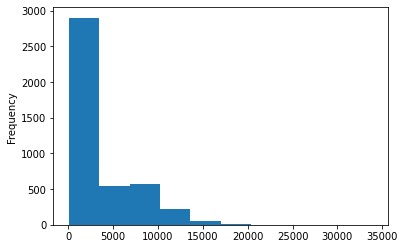

In [17]:
#I want to subset and check for normality amongst those who have a non-zero payout amount, since ~80% of all records are zero. 

amount = NA_EDA.AmountPaid.loc[NA_EDA.AmountPaid != 0]

mean = round(amount.mean(), 3)
std = round(amount.std(), 3)
median = round(amount.median(), 3)
print(mean, std, median)
amount.plot.hist();

Hm. Too dense for this scale, presumably trying to accommodate that $33,000 max.

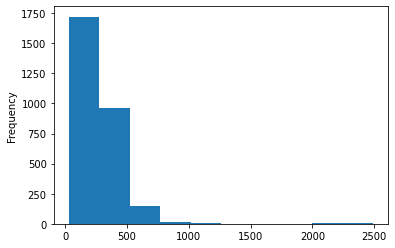

In [18]:
payout = amount
low_payout = payout[payout <= 2500]
high_payout = payout[payout >2500]

low_payout.plot.hist();

Oh wow. Okay, so I guess it's even finer. 

In [19]:
small_payout = payout[payout <= 500]
midsize_payout = payout.loc[(payout > 500) & (payout < 2500)]
high_payout = payout[payout > 2500]
print(len(small_payout), len(midsize_payout), len(high_payout))

2652 215 1433


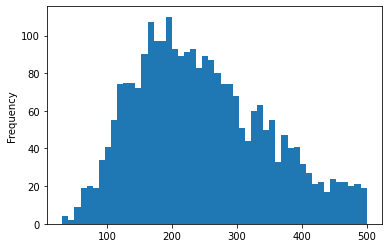

In [20]:
small_payout.plot.hist(bins = 50);

So, here we see 2650 payouts, and a vaguely normal distribution centered around $200 or so. 
This represents roughly 62% of all claims.

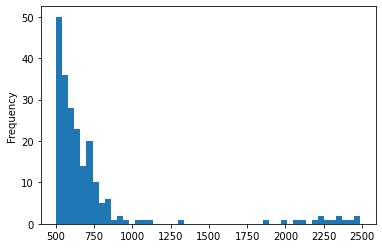

In [21]:
midsize_payout.plot.hist(bins = 50);

Here we see a mere 5% of claims in a sort of dead-zone. The tail from the normal-ish distribution above tapers off, then virtually no payouts occur until around 500, where another vaguely normal distribution emerges again, this time centered around $7000 or so.

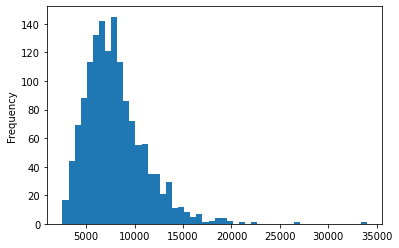

In [22]:
high_payout.plot.hist(bins = 50);

1433 1392 1317
41 116
0.9713886950453594 0.9190509420795534


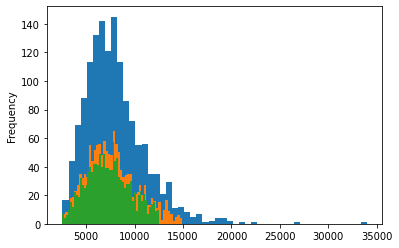

In [103]:
amount = NA_EDA.AmountPaid.loc[NA_EDA.AmountPaid >2500]
rangecount = NA_EDA.AmountPaid.loc[(NA_EDA.AmountPaid > 2500) & (NA_EDA.AmountPaid < 15000)]
rangecount2 = NA_EDA.AmountPaid.loc[(NA_EDA.AmountPaid > 2500) & (NA_EDA.AmountPaid < 12500)]

amount.plot.hist(bins = 50)
rangecount.plot.hist(bins = 50)
rangecount2.plot.hist(bins = 50)
original = len(amount)
at15 = len(rangecount)
at12_5 = len(rangecount2)
print(original, at15, at12_5)
print(original - at15, original- at12_5)
print(1 - (41/1433), 1- (116/1433))

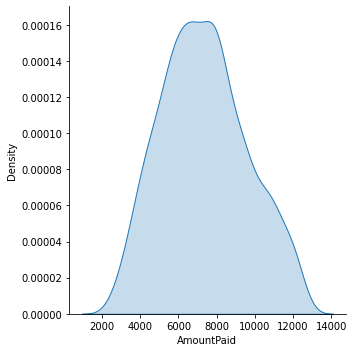

In [102]:
sns.displot(rangecount2, kind = 'kde', fill = True);

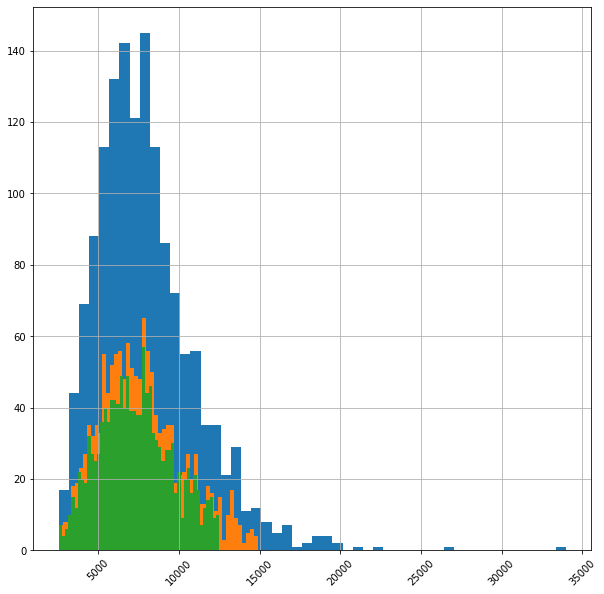

In [85]:
listset = [amount, rangecount, rangecount2]
for i in listset:
    i.hist(figsize = (10,10), xrot = 45, bins = 50)
plt.show()

<AxesSubplot:ylabel='Frequency'>

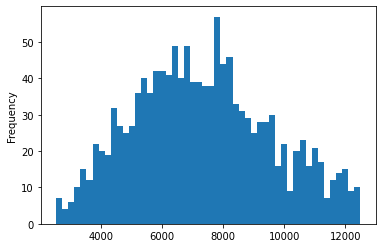

In [78]:
rangecount2.plot.hist(bins = 50)

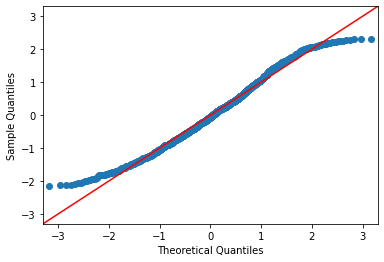

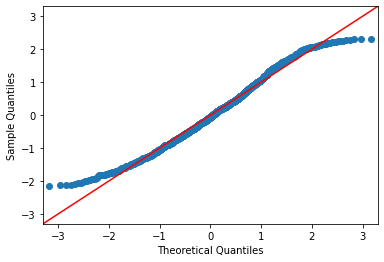

In [104]:
import statsmodels.api as sm
sm.qqplot(rangecount2, fit = True, line = '45')

In [23]:
high_payout.describe()

count     1433.000000
mean      7962.787146
std       3113.327550
min       2541.370000
25%       5816.560000
50%       7513.330000
75%       9504.340000
max      33977.710000
Name: AmountPaid, dtype: float64

In [24]:
9504 - 7962

1542

In [26]:
1542*3 + 7962

12588

Here we see the remaining ~30% of claims, but note the scale of the x-axis: while the y-axis shows max values near the same frequency counts, the x axis is ticked at 5000, versus above where it is at 100! In reality, the following plot is more accurate.

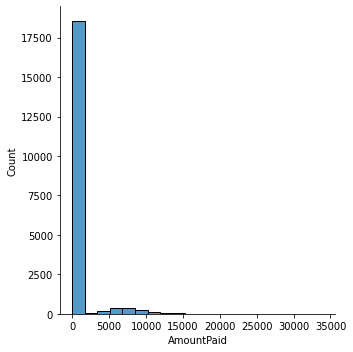

In [21]:
sns.displot(NA_EDA, x = 'AmountPaid', bins = 20);

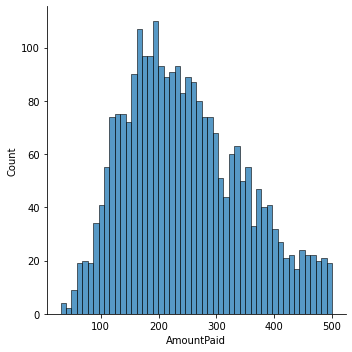

In [22]:
#Mode 1, at $10 increments. 

sns.displot(small_payout, bins = int(500/10));

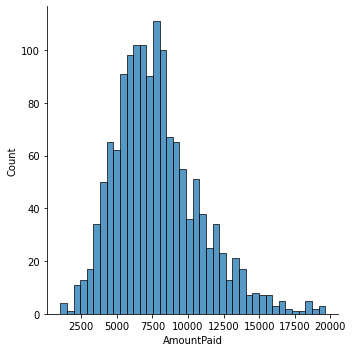

In [23]:
#Since the high-end peters out around $20,000, we'll lop off the outliers, and then zoom in a bit. 
#This is approximately $500 increments, and is the nearly invisible mode 2 from above. 

revised_high_payout = payout.loc[(payout > 1000) & (payout < 20000)]

sns.displot(revised_high_payout, bins = 40);

So, in short, we have a bimodal distribution, where both modes are independently ~normal. 

These are roughly 62% of all payouts with a mean near 200 dollars, and 33% near 8000.

Since these payment amounts are clustered in the two modes, I'll likely consolidate these into categories: 'Small Payouts' (<1000) and 'Large Payouts (>1000) to reduce dimensionality. 

From the Claims dataset, there are no further predictors to consider. From the predictors dataset, we know types/formats/missingness/tidiness/etc. 

Now, with respect to the subsequent loss experience, I'm not sure we can use or will need anything further from that set (except of course the dependent variable -- future_clm_ind). 

From the instructions (emphasis added): 

>Step 1
 Use the above datasets to: 
> - Aggregate Dataset 1 at the hhld_id to create the following claim count variables:
>     - Number of At Fault claims in each of the last 5 years from application date
>     - Number of Not At Fault claims in each of the last 5 years from application date
>
> - Merge the Datasets 2 and 3, and the aggregated form of Dataset 1 using hhld_id
> - Create a model where you are trying to identify if the applicant *had a future loss* (future_clm_ind) using the information  
known on or before the application date.

So, it seems the loss ratio, premium, and loss amount aren't relevant. I'm not 100% clear about the 'Premium' variable. The instructions say, of Dataset 3, 'All information gathered after application date.' Be that as it may, in general, wouldn't we *know* what a policy holder was paying for insurance? Again, from the instructions, 'Create a model...using the information known on or before the application date.' So, since we are saying everything in dataset 3 is 'after', then on that criteria we should leave this feature out of the model. Furthermore, I suppose the premium is in essence a quantification of what we know about the policy holder at the time of issuance. So to that extent, we wouldn't be adding information so much as summarizing it by including the price. 

In light of all that, I'm going to remove all the "Subsequent Loss" items except for 'future_clm_ind.'



In [24]:
#Examining dependent variables and related items.
outputs = NA_EDA.filter(regex = '^Y')
outputs

,YPremium,YLossAmt,YLossRatio,YFutureClaim
0,167.00,0.000000,0.000000,0
1,120.24,0.000000,0.000000,0
2,120.24,0.000000,0.000000,0
3,167.00,0.000000,0.000000,0
4,150.30,0.000000,0.000000,0
...,...,...,...,...
19995,167.00,0.000000,0.000000,0
19996,251.20,0.000000,0.000000,0
19997,80.00,0.000000,0.000000,0
19998,247.00,805.084306,3.259451,1


In [25]:
#Copying dataset as checkpoint prior to proceeding.
#Removing DV-related items that aren't the targeted outcome. 

WorkingModel = NA_EDA.copy(deep = True)
WorkingModel.drop(columns = ['YLossRatio', 'YLossAmt', 'YPremium'], inplace = True)

In [26]:
print(NA_EDA.shape, WorkingModel.shape)

(20000, 59) (20000, 56)


#Feature Engineering

I want to start by taking a closer look at the predictors we are working with to see if there's anything I can get rid of, shrink, consolidate, or otherwise simplify. 

In [27]:
for i in QuantPreds:
    print('|', i, '|')

| Time_W_Carr |
| Credit_Score |
| Min_Mon_Lic |
| Max_Mon_Lic |
| Hoh_Mon_Lic |
| Max_Age |
| Min_Age |
| Hoh_Age |
| Avg_Age |
| Avg_Mon_Lic |
| Avg_Majr_Viol |
| Avg_Minr_Viol |
| Cnt_Yth |
| Cnt_Female |
| Cnt_Male |
| Cnt_Married |
| Cnt_Single |
| Cnt_Auto |
| Cnt_Mtrcyc |
| Cnt_Majr_Viol |
| Cnt_Minr_Viol |
| Cnt_Lic_Susp |
| Drvr_Cnt |
| Veh_Cnt |
| Veh_Lien_Cnt |
| Veh_Lease_Cnt |
| Veh_Own_Cnt |
| Veh_W_Coll_Cnt |
| Veh_W_Comp_Cnt |
| Veh_W_Ers_Cnt |


In [28]:
for i in Bin_Preds:
    print('|', i, '|')

| Monthly_Pay_Ind |
| Homeowner_Ind |
| Fire_Ind |
| Inforce_Ind |
| Hoh_Married |


In [29]:
for i in Cat_Preds:
    print('|', i, '|')

| Zipcode |
| Curnt_Bi_Upp |
| Curnt_Bi_Low |
| Curnt_Insurer |
| Prior_Bi |


In [30]:
WorkingModel['Drvr_Cnt'].value_counts()

1    11461
2     6822
3     1301
4      416
Name: Drvr_Cnt, dtype: int64

Looks like we can send the above to categorical, just need to bin it. 

In [31]:
QuantPreds.remove('Drvr_Cnt')

In [32]:
Cat_Preds.append('Drvr_Cnt')

In [33]:
WorkingModel['Veh_Cnt'].value_counts()

1    14297
2     4285
3     1144
4      274
Name: Veh_Cnt, dtype: int64

In [34]:
#Likewise
QuantPreds.remove('Veh_Cnt')
Cat_Preds.append('Veh_Cnt')

In [35]:
for i in Cnt_preds: 
    print(WorkingModel[i].value_counts())

0    18371
1     1529
2       94
3        6
Name: Cnt_Yth, dtype: int64
1    9739
0    7597
2    2369
3     267
4      28
Name: Cnt_Female, dtype: int64
1    9818
0    7600
2    2300
3     264
4      18
Name: Cnt_Male, dtype: int64
0    10791
2     5657
1     3463
3       79
4       10
Name: Cnt_Married, dtype: int64
1    12410
0     6167
2     1105
3      274
4       44
Name: Cnt_Single, dtype: int64
1    14035
2     4144
3     1092
0      466
4      263
Name: Cnt_Auto, dtype: int64
0    19347
1      587
2       41
3       25
Name: Cnt_Mtrcyc, dtype: int64
0    19706
1      233
2       35
3       18
5        4
4        4
Name: Cnt_Majr_Viol, dtype: int64
0    15817
1     2962
2      892
3      223
4       81
5       25
Name: Cnt_Minr_Viol, dtype: int64
0    19777
1      214
2        9
Name: Cnt_Lic_Susp, dtype: int64


In [36]:
#Yeah, all of these, too, are essentially categorical. Let's move them:

for i in Cnt_preds:
    QuantPreds.remove(i)
    Cat_Preds.append(i)

In [37]:
WorkingModel['Avg_Minr_Viol'].value_counts()

0.000000    15817
1.000000     1894
0.500000     1186
2.000000      409
0.333333      261
1.500000       99
0.666667       86
3.000000       82
0.250000       82
4.000000       28
0.750000       17
1.333333       14
2.500000       12
5.000000        6
1.666667        4
1.250000        3
Name: Avg_Minr_Viol, dtype: int64

It looks like these will be more appropriately rendered as continous, but they might well be dropped, since we have count already by household. I'm not sure -- for the goal of predicting individual policy-holder's claims-- that it will matter at all that we have this average-per-house information: that seems more useful for a non-individual-level analysis. I suppose some kind of baseline might be inferred, but since ~75% of all policyholders have 0 claims, having even 1 is suggestive. I'll return to this if needed. 

In [38]:
veh_preds = WorkingModel.filter(regex = '^Veh')
for i in veh_preds:
    print(WorkingModel[i].value_counts())

1    14297
2     4285
3     1144
4      274
Name: Veh_Cnt, dtype: int64
0.0    19987
1.0       11
2.0        2
Name: Veh_Lien_Cnt, dtype: int64
0    19228
1      769
2        3
Name: Veh_Lease_Cnt, dtype: int64
0    12233
1     6707
2      941
3      112
4        7
Name: Veh_Own_Cnt, dtype: int64
1    12583
0     5069
2     2111
3      225
4       12
Name: Veh_W_Coll_Cnt, dtype: int64
1    12552
0     5090
2     2115
3      224
4       19
Name: Veh_W_Comp_Cnt, dtype: int64
1    15078
0     4107
2      716
3       71
4       28
Name: Veh_W_Ers_Cnt, dtype: int64


In [39]:
#Can go to categorical

for i in veh_preds:
    try:                             #Nice.
        QuantPreds.remove(i)
        Cat_Preds.append(i)
    except:
        Cat_Preds.append(i)
        


In [40]:
print(WorkingModel.Time_W_Carr.value_counts().sort_values())

4.5     319
3.5     430
4.0     585
2.5     586
1.5     749
3.0     809
2.0     960
0.5    1046
1.0    1267
5.0    5433
0.0    7816
Name: Time_W_Carr, dtype: int64


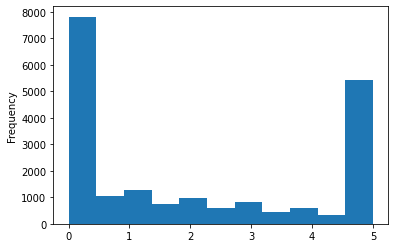

In [41]:
WorkingModel.Time_W_Carr.plot.hist(bins = 11);

Hm. Not only could I bin it, I might could binarize it, since the overwhelming majority of people either have 0-1 years or 4.5+

In [42]:
QuantPreds.remove('Time_W_Carr')
Cat_Preds.append('Time_W_Carr')

In [43]:
for i in Cat_Preds:
    print('|', i, '|')
    
print('__________________')

for i in Bin_Preds:
    print('|', i, '|')
    
print('__________________')
    
for i in QuantPreds:
    print('|', i, '|')

| Zipcode |
| Curnt_Bi_Upp |
| Curnt_Bi_Low |
| Curnt_Insurer |
| Prior_Bi |
| Drvr_Cnt |
| Veh_Cnt |
| Cnt_Yth |
| Cnt_Female |
| Cnt_Male |
| Cnt_Married |
| Cnt_Single |
| Cnt_Auto |
| Cnt_Mtrcyc |
| Cnt_Majr_Viol |
| Cnt_Minr_Viol |
| Cnt_Lic_Susp |
| Veh_Cnt |
| Veh_Lien_Cnt |
| Veh_Lease_Cnt |
| Veh_Own_Cnt |
| Veh_W_Coll_Cnt |
| Veh_W_Comp_Cnt |
| Veh_W_Ers_Cnt |
| Time_W_Carr |
__________________
| Monthly_Pay_Ind |
| Homeowner_Ind |
| Fire_Ind |
| Inforce_Ind |
| Hoh_Married |
__________________
| Credit_Score |
| Min_Mon_Lic |
| Max_Mon_Lic |
| Hoh_Mon_Lic |
| Max_Age |
| Min_Age |
| Hoh_Age |
| Avg_Age |
| Avg_Mon_Lic |
| Avg_Majr_Viol |
| Avg_Minr_Viol |


In [44]:
WorkingModel.to_csv('Checkpoint.csv', index = False, index_label = False)

In [45]:
checkpoint = pd.read_csv('Checkpoint.csv')

In [46]:
checkpoint.head(1)

,Cust_ID,Drvr_Cnt,Veh_Cnt,Min_Age,Hoh_Age,Max_Age,Avg_Age,Min_Mon_Lic,Hoh_Mon_Lic,Max_Mon_Lic,...,2016_AF,2012_NAF,2013_NAF,2014_NAF,2015_NAF,2016_NAF,Total_AF,Total_NAF,Total_Prior,AmountPaid
0,1,1,1,57.959522,57.959522,57.959522,57.959522,474.90046,446.286652,446.286652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
checkpoint[Bin_Preds].head(1)

,Monthly_Pay_Ind,Homeowner_Ind,Fire_Ind,Inforce_Ind,Hoh_Married
0,1,0,0,1,False


In [48]:
for i in Bin_Preds:
    print(checkpoint[i].value_counts())

0    13971
1     6029
Name: Monthly_Pay_Ind, dtype: int64
0    10843
1     9157
Name: Homeowner_Ind, dtype: int64
0    12023
1     7977
Name: Fire_Ind, dtype: int64
1    12990
0     7010
Name: Inforce_Ind, dtype: int64
False    10791
True      9209
Name: Hoh_Married, dtype: int64


In [49]:
checkpoint['Hoh_Married'].info

<bound method Series.info of 0        False
1        False
2         True
3         True
4         True
         ...  
19995    False
19996    False
19997     True
19998     True
19999     True
Name: Hoh_Married, Length: 20000, dtype: bool>

In [50]:
from sklearn.preprocessing import Binarizer

bn = Binarizer(threshold = 0.9)
checkpoint[Bin_Preds] = bn.transform([checkpoint[Bin_Preds]][0])

C:\Users\goffm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Binarizer was fitted without feature names
  warnings.warn(


In [51]:
checkpoint['Hoh_Married'].value_counts()

0    10791
1     9209
Name: Hoh_Married, dtype: int64

Looks good. Let's proceed with considering the categorical variables-- we'll encode them similarly, but first we need to distinguish between those that will be nominal and those that will be ordinal.

In [52]:
checkpoint[Cat_Preds].head(3)

,Zipcode,Curnt_Bi_Upp,Curnt_Bi_Low,Curnt_Insurer,Prior_Bi,Drvr_Cnt,Veh_Cnt,Cnt_Yth,Cnt_Female,Cnt_Male,...,Cnt_Minr_Viol,Cnt_Lic_Susp,Veh_Cnt,Veh_Lien_Cnt,Veh_Lease_Cnt,Veh_Own_Cnt,Veh_W_Coll_Cnt,Veh_W_Comp_Cnt,Veh_W_Ers_Cnt,Time_W_Carr
0,51365,25,25,GEICO,100000.0,1,1,0,0,1,...,0,0,1,0.0,0,0,1,1,1,0.5
1,16107,100,100,GEICO,25000.0,1,1,0,1,0,...,0,0,1,0.0,0,0,1,1,1,0.0
2,68294,25,25,MISSING,0.0,2,1,0,1,1,...,0,0,1,0.0,0,1,1,1,1,0.0


In [53]:
cp_sanityCheck = []
for cp in checkpoint[Cat_Preds].columns:
    cp_sanityCheck.append(cp)
    
assert len(cp_sanityCheck) == len(Cat_Preds)

print(cp_sanityCheck)

['Zipcode', 'Curnt_Bi_Upp', 'Curnt_Bi_Low', 'Curnt_Insurer', 'Prior_Bi', 'Drvr_Cnt', 'Veh_Cnt', 'Cnt_Yth', 'Cnt_Female', 'Cnt_Male', 'Cnt_Married', 'Cnt_Single', 'Cnt_Auto', 'Cnt_Mtrcyc', 'Cnt_Majr_Viol', 'Cnt_Minr_Viol', 'Cnt_Lic_Susp', 'Veh_Cnt', 'Veh_Lien_Cnt', 'Veh_Lease_Cnt', 'Veh_Own_Cnt', 'Veh_W_Coll_Cnt', 'Veh_W_Comp_Cnt', 'Veh_W_Ers_Cnt', 'Time_W_Carr']


In [54]:
checkpoint.Veh_Cnt.value_counts()

1    14297
2     4285
3     1144
4      274
Name: Veh_Cnt, dtype: int64

In [55]:
checkpoint.Drvr_Cnt.value_counts()

1    11461
2     6822
3     1301
4      416
Name: Drvr_Cnt, dtype: int64

It looks like anything with 'cnt' in the variable name is nominal or suitable for binning. Likewise, I don't see any reason to think zip code or previous carrier would have any ordinal implication.
On the other hand, we've seen previously that BI-limits, as well as duration of time with current carrier are both ordinal. The time-with-carrier, however, is so unevenly distributed, I may still binarize it into 'new' and 'old.'

In [56]:
ordinal_vars = ['Curnt_Bi_Upp', 'Curnt_Bi_Low', 'Time_W_Carr', 'Prior_Bi']
nominal_vars = [i for i in Cat_Preds if i not in ordinal_vars]

In [57]:
Cat_Preds_Ordinal = [i for i in ordinal_vars]
Cat_Preds_Nominal = [i for i in nominal_vars]

assert (len(Cat_Preds_Ordinal) + len(Cat_Preds_Nominal)) == len(Cat_Preds)

In [58]:
from sklearn.preprocessing import LabelEncoder

gle = LabelEncoder()

for i in Cat_Preds_Nominal: 
    catLabels = gle.fit_transform(checkpoint[i])
    nominal_mapping = {index: label for index, label in enumerate(gle.classes_)}
    newName = f'{i}_Label'
    checkpoint[newName] = catLabels

In [59]:
checkpoint.columns

Index(['Cust_ID', 'Drvr_Cnt', 'Veh_Cnt', 'Min_Age', 'Hoh_Age', 'Max_Age',
       'Avg_Age', 'Min_Mon_Lic', 'Hoh_Mon_Lic', 'Max_Mon_Lic', 'Avg_Mon_Lic',
       'Cnt_Yth', 'Cnt_Female', 'Cnt_Male', 'Cnt_Married', 'Cnt_Single',
       'Hoh_Married', 'Cnt_Auto', 'Cnt_Mtrcyc', 'Avg_Majr_Viol',
       'Cnt_Majr_Viol', 'Cnt_Minr_Viol', 'Avg_Minr_Viol', 'Cnt_Lic_Susp',
       'Curnt_Insurer', 'Time_W_Carr', 'Inforce_Ind', 'Prior_Bi', 'Fire_Ind',
       'Homeowner_Ind', 'Veh_Lien_Cnt', 'Veh_Lease_Cnt', 'Veh_Own_Cnt',
       'Monthly_Pay_Ind', 'Veh_W_Coll_Cnt', 'Veh_W_Comp_Cnt', 'Veh_W_Ers_Cnt',
       'Curnt_Bi_Low', 'Curnt_Bi_Upp', 'Credit_Score', 'Zipcode',
       'YFutureClaim', '2012_AF', '2013_AF', '2014_AF', '2015_AF', '2016_AF',
       '2012_NAF', '2013_NAF', '2014_NAF', '2015_NAF', '2016_NAF', 'Total_AF',
       'Total_NAF', 'Total_Prior', 'AmountPaid', 'Zipcode_Label',
       'Curnt_Insurer_Label', 'Drvr_Cnt_Label', 'Veh_Cnt_Label',
       'Cnt_Yth_Label', 'Cnt_Female_Label', 'Cnt_Male

Here, we can see the logic of the label-encoder, mapping a novel variable that corresponds to the original variables and their encoding. Since, we will only *use* the label-encoded versions, we can drop the originals. 

In [358]:
#Dropping, and sanity-checking since the LabelEncoder sometimes does funny stuff.
for i in Cat_Preds_Nominal: 
    try:
        checkpoint.drop(columns = [i], inplace = True)
    except: 
        continue

In [359]:
checkpoint.head()

,Cust_ID,Min_Age,Hoh_Age,Max_Age,Avg_Age,Min_Mon_Lic,Hoh_Mon_Lic,Max_Mon_Lic,Avg_Mon_Lic,Hoh_Married,...,Cnt_Mtrcyc_Label,Cnt_Majr_Viol_Label,Cnt_Minr_Viol_Label,Cnt_Lic_Susp_Label,Veh_Lien_Cnt_Label,Veh_Lease_Cnt_Label,Veh_Own_Cnt_Label,Veh_W_Coll_Cnt_Label,Veh_W_Comp_Cnt_Label,Veh_W_Ers_Cnt_Label
0,1,57.959522,57.959522,57.959522,57.959522,474.900460,446.286652,446.286652,446.286652,0,...,0,0,0,0,0,0,0,1,1,1
1,2,43.273825,43.273825,43.273825,43.273825,327.285898,327.285898,327.285898,327.285898,0,...,0,0,0,0,0,0,0,1,1,1
2,3,25.234646,32.296455,32.296455,28.765551,110.815758,195.557459,195.557459,153.186608,1,...,0,0,0,0,0,0,1,1,1,1
3,4,58.391477,58.391477,58.391477,58.391477,508.697725,508.697725,508.697725,508.697725,1,...,0,0,0,0,0,0,0,1,1,1
4,5,40.654362,53.830470,53.830470,47.242416,295.852339,453.965637,453.965637,374.908988,1,...,0,0,0,0,0,0,1,1,1,1


Finally, we need to do the similar process as above, but for the ordinal values. 

In [360]:
for i in Cat_Preds_Ordinal: 
    print(checkpoint[i].value_counts())

25     9202
100    4698
50     4669
250    1431
Name: Curnt_Bi_Upp, dtype: int64
25     9202
100    4698
50     4669
250    1431
Name: Curnt_Bi_Low, dtype: int64
0.0    7816
5.0    5433
1.0    1267
0.5    1046
2.0     960
3.0     809
1.5     749
2.5     586
4.0     585
3.5     430
4.5     319
Name: Time_W_Carr, dtype: int64
0.0         7010
25000.0     4269
100000.0    4156
50000.0     2722
250000.0    1843
Name: Prior_Bi, dtype: int64


In [361]:
#Restructuring the time-with-carrier variable, since it is so unevenly distributed:

def carrier(x):
    status = 0
    if x == 0.0 or x < 1.0:
        status+= 1.0
    if x >= 1.0 and x < 5.0:
        status+= 2.0
    if x >= 5.0:
        status+= 3.0
        
    return status

checkpoint['Time_CurrentCarrier'] = checkpoint['Time_W_Carr'].apply(lambda x: carrier(x))

In [362]:
checkpoint.Time_CurrentCarrier.value_counts()

1.0    8862
2.0    5705
3.0    5433
Name: Time_CurrentCarrier, dtype: int64

In [363]:
checkpoint.drop('Time_W_Carr', axis = 1, inplace = True)
Cat_Preds_Ordinal.remove('Time_W_Carr')
Cat_Preds_Ordinal.append('Time_CurrentCarrier')

In [364]:
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
 
goe = OrdinalEncoder()

for i in Cat_Preds_Ordinal:
    
    CPO1 = asarray(checkpoint[i])
    CPO2 = np.sort(CPO1.reshape(-1,1))
    Ooutputs = goe.fit_transform(CPO2)
    ordinal_mapping = {index: label for index, label in enumerate(gle.classes_)}
    newname = f'O_{i}'
    checkpoint[newname]= Ooutputs

In [369]:
print(f'Original Data (In years): {WorkingModel.Time_W_Carr.unique()}')
print(f'After transformation (in self-specified scale): {checkpoint.Time_CurrentCarrier.unique()}')
print(f'New Encoding (as ordinal scale): {checkpoint.O_Time_CurrentCarrier.unique()}')

Original Data (In years): [0.5 0.  1.  5.  4.  1.5 2.5 3.5 3.  2.  4.5]
After transformation (in self-specified scale): [1. 2. 3.]
New Encoding (as ordinal scale): [0. 1. 2.]


In [375]:
#Dropping pre-encoding ordinal variables:
for i in Cat_Preds_Ordinal:
    try:
        checkpoint.drop(columns = [i], inplace = True)
    except:
        continue

In [377]:
print(*Cat_Preds_Nominal, sep = '\n')

print('\n', checkpoint.iloc[0], '\n')
      
print(f'Length of DF after encoding variables by type: {len(checkpoint)} \n')

print(f'Number of columns in encoded DF: {len(checkpoint.columns)} \n')

print(f'The original dataset contained {len(NA_EDA.columns)} variables; after deleting irrelevant "y"-variables the new dataset contains {len(checkpoint.columns)}')

Zipcode
Curnt_Insurer
Drvr_Cnt
Veh_Cnt
Cnt_Yth
Cnt_Female
Cnt_Male
Cnt_Married
Cnt_Single
Cnt_Auto
Cnt_Mtrcyc
Cnt_Majr_Viol
Cnt_Minr_Viol
Cnt_Lic_Susp
Veh_Cnt
Veh_Lien_Cnt
Veh_Lease_Cnt
Veh_Own_Cnt
Veh_W_Coll_Cnt
Veh_W_Comp_Cnt
Veh_W_Ers_Cnt

 Cust_ID                    1.000000
Min_Age                   57.959522
Hoh_Age                   57.959522
Max_Age                   57.959522
Avg_Age                   57.959522
Min_Mon_Lic              474.900460
Hoh_Mon_Lic              446.286652
Max_Mon_Lic              446.286652
Avg_Mon_Lic              446.286652
Hoh_Married                0.000000
Avg_Majr_Viol              0.000000
Avg_Minr_Viol              0.000000
Inforce_Ind                1.000000
Fire_Ind                   0.000000
Homeowner_Ind              0.000000
Monthly_Pay_Ind            1.000000
Credit_Score             698.933117
YFutureClaim               0.000000
2012_AF                    0.000000
2013_AF                    0.000000
2014_AF                    0.000000


In [378]:
checkpoint.YFutureClaim.value_counts()

0    19131
1      869
Name: YFutureClaim, dtype: int64

Excellent. Everything looks exactly as anticipated. 

We will now move onto transforming the 

In [386]:
checkpoint.head(1)

,Cust_ID,Min_Age,Hoh_Age,Max_Age,Avg_Age,Min_Mon_Lic,Hoh_Mon_Lic,Max_Mon_Lic,Avg_Mon_Lic,Hoh_Married,...,Veh_Lien_Cnt_Label,Veh_Lease_Cnt_Label,Veh_Own_Cnt_Label,Veh_W_Coll_Cnt_Label,Veh_W_Comp_Cnt_Label,Veh_W_Ers_Cnt_Label,O_Curnt_Bi_Upp,O_Curnt_Bi_Low,O_Prior_Bi,O_Time_CurrentCarrier
0,1,57.959522,57.959522,57.959522,57.959522,474.90046,446.286652,446.286652,446.286652,0,...,0,0,0,1,1,1,0.0,0.0,3.0,0.0


In [380]:
checkpoint.to_csv('Checkpoint2.csv', index = False, index_label = False)

Having completed all cleaning and preprocessing, we will now move on to feature engineering, EDA/KDD, and feature selection, prior to model-building. 

### Part 5: KDD and Feature-Engineering

Normally, I would utilize multiple other features at this point in the process. For example, it's quite a bit easier to do this kind of thing with automated tools both inside (Mito, for example) and outside (Excel/Sheets, Weka, etc.) of the Python ecosystem. However, given those tools are kind of shortcutting some of the lower-level work with drag-and-drop UI or API-specific programming, I've opted not to include them here. In practice, I usually would, however, yielding much more concise reporting and faster turnaround. 

In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spstats
import matplotlib as mpl
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette

%matplotlib inline
sns.set_style('darkgrid')
mpl.style.reload_library() 
mpl.style.use('classic')
mpl.rcParams['figure.facecolor'] = (1,1,1,0)
mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['figure.dpi'] = 100
pd.set_option('display.max_columns',100)

In [283]:
KDD_SF = pd.read_csv('Checkpoint2.csv')

In [284]:
KDD_SF.head(1)

,Cust_ID,Min_Age,Hoh_Age,Max_Age,Avg_Age,Min_Mon_Lic,Hoh_Mon_Lic,Max_Mon_Lic,Avg_Mon_Lic,Hoh_Married,Avg_Majr_Viol,Avg_Minr_Viol,Inforce_Ind,Fire_Ind,Homeowner_Ind,Monthly_Pay_Ind,Credit_Score,YFutureClaim,2012_AF,2013_AF,2014_AF,2015_AF,2016_AF,2012_NAF,2013_NAF,2014_NAF,2015_NAF,2016_NAF,Total_AF,Total_NAF,Total_Prior,AmountPaid,Zipcode_Label,Curnt_Insurer_Label,Drvr_Cnt_Label,Veh_Cnt_Label,Cnt_Yth_Label,Cnt_Female_Label,Cnt_Male_Label,Cnt_Married_Label,Cnt_Single_Label,Cnt_Auto_Label,Cnt_Mtrcyc_Label,Cnt_Majr_Viol_Label,Cnt_Minr_Viol_Label,Cnt_Lic_Susp_Label,Veh_Lien_Cnt_Label,Veh_Lease_Cnt_Label,Veh_Own_Cnt_Label,Veh_W_Coll_Cnt_Label,Veh_W_Comp_Cnt_Label,Veh_W_Ers_Cnt_Label,O_Curnt_Bi_Upp,O_Curnt_Bi_Low,O_Prior_Bi,O_Time_CurrentCarrier
0,1,57.959522,57.959522,57.959522,57.959522,474.90046,446.286652,446.286652,446.286652,0,0.0,0.0,1,0,0,1,698.933117,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45,3,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,1,1,0.0,0.0,3.0,0.0


In [285]:
Var_List = list(KDD_SF.columns)
Features = [i for i in Var_List if i != 'YFutureClaim']
X = KDD_SF[Features]
y = KDD_SF['YFutureClaim']

In [286]:
assert len(Features) == (len(KDD_SF.columns)-1)
y.value_counts()

0    19131
1      869
Name: YFutureClaim, dtype: int64

All good.

In [287]:
Ord_Preds = []
Nom_Preds = []
Quant_Preds = []
Bin_Preds = []

for i in Var_List: 
    if i.startswith('O'):
        Ord_Preds.append(i)
    
    if i.endswith('Label'):
        Nom_Preds.append(i)
        
    if i.startswith('Avg') or i.startswith('Min') or i == 'Hoh_Age' or i == 'Hoh_Mon_Lic' or i.startswith('Max') or i.endswith('Paid') or i.endswith('Score') or i.endswith('Viol'):
        Quant_Preds.append(i)
        
    if i.endswith('AF') or i.endswith('Prior') or i.endswith('Ind') or i.endswith('Married'):
        Bin_Preds.append(i)


In [288]:
len(Ord_Preds) + len(Quant_Preds) + len(Nom_Preds) + len(Bin_Preds) #Cust_ID + YFutureClaim = __ + 2 

54

Excellent. Let's proceed.

First, let's check on our distributions and make sure assumptions of normality, etc., are met with our quantitative features.

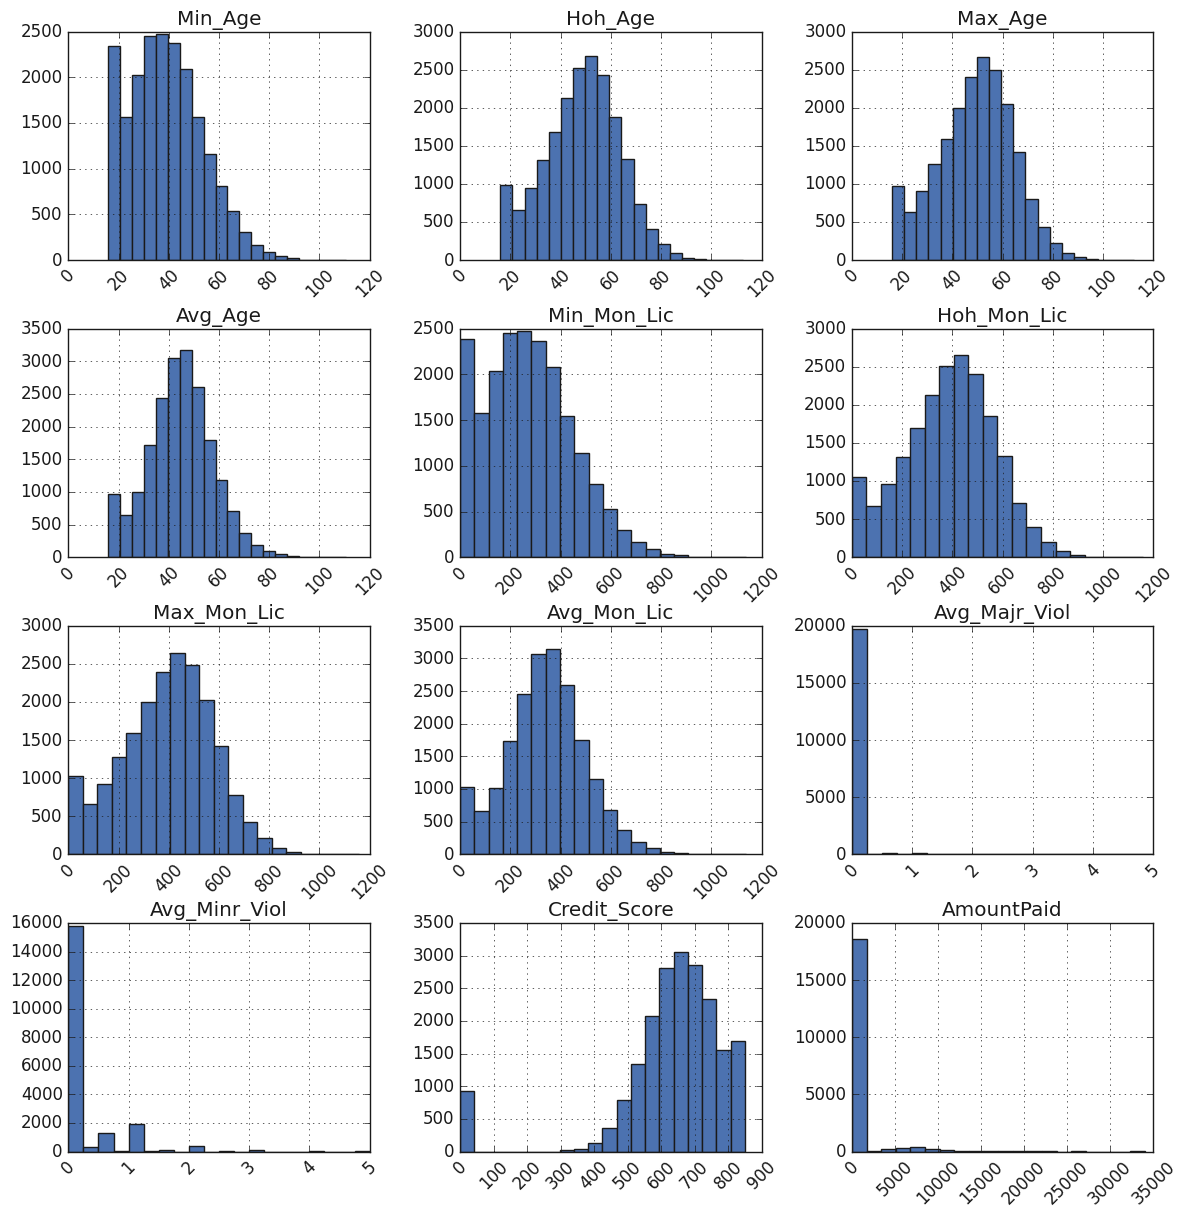

In [289]:
KDD_SF[Quant_Preds].hist(figsize = (14,14), xrot = 45, bins = 20)
plt.show()

So, for the most part, these are approximately normal, with credit score and minimum months licensed showing some irregularity due to young people.

As discussed above, the amount paid is actually a pair of approximately normal distributions, categorizable with means around 200 and 7000 dollars, and were quite well-captured (~90-95%) by a split at greater-than or less-than 1000 dollars. Let's implement that, then move it to a categorical predictor. 

In [290]:
def payout(x):
    if x == 0:
        return 0
    elif x > 0 and x <1000:
        return 1
    elif x > 1000:
        return 2
    else:
        return 9

In [291]:
KDD_SF['PaymentPriorClaim'] = KDD_SF['AmountPaid'].apply(lambda x: payout(x))

In [292]:
KDD_SF.PaymentPriorClaim.value_counts()

0    15700
1     2848
2     1452
Name: PaymentPriorClaim, dtype: int64

In [293]:
#No '9's, so we are sane, and above the 'low-payout' count was 2650 when the threshold was $500, so this distribution checks-out.

KDD_SF.drop('AmountPaid', axis = 1, inplace =True)

In [294]:
Quant_Preds.remove('AmountPaid')

In [295]:
Nom_Preds.append('PaymentPriorClaim')

We can also see here that the average major/minor violations isn't really working as a continuous predictor, and we have the counts binned in the nominal set. 

Total: 4183


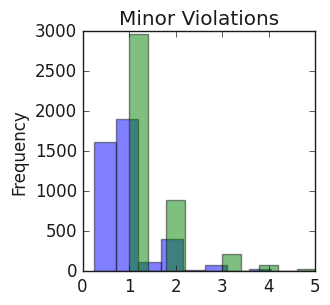

In [296]:
minorV = KDD_SF.Avg_Minr_Viol.loc[KDD_SF.Avg_Minr_Viol !=0]
print(f'Total: {len(minorV)}')
plt.title('Minor Violations')
minorV.plot.hist(figsize = (3,3), color = 'blue', alpha = 0.5);
minorV_count = KDD_SF.Cnt_Minr_Viol_Label.loc[KDD_SF.Cnt_Minr_Viol_Label !=0]
minorV_count.plot.hist(figsize = (3,3), color = 'green', alpha = 0.5);

Total: 294


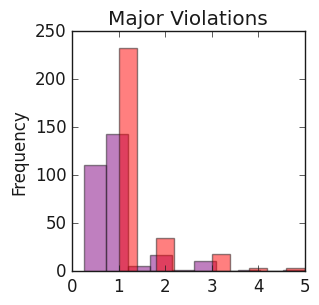

In [297]:
majorV = KDD_SF.Avg_Majr_Viol.loc[KDD_SF.Avg_Majr_Viol !=0]
print(f'Total: {len(majorV)}')
plt.title('Major Violations')
majorV.plot.hist(figsize = (3,3), color = 'purple', alpha = 0.5);
majorV_count = KDD_SF.Cnt_Majr_Viol_Label.loc[KDD_SF.Cnt_Majr_Viol_Label !=0]
majorV_count.plot.hist(figsize = (3,3), color = 'red', alpha = 0.5);

To me, this suggests sufficient similarity to just keep one of these. The metadata says the avg_minr_viol is the 'average number of minor violations in the household,' so does that mean the denominator is number-of-people? Or is it using time-- for example, over the last 5 years? I don't really see an obvious reason why either matters all that much, and we can capture nearly the same information with just retaining count. 

In [298]:
viols = ['Avg_Minr_Viol', 'Avg_Majr_Viol']
KDD_SF.drop(columns = viols, inplace = True)

In [299]:
for i in viols:
    Quant_Preds.remove(i)

Next, we will check intra-feature correlation. Our set of IVs is quite large, so we want to check for and correct/modify appropriately:

1) Multicollinearity
2) Latent variables, PCs, and other factor-related items
3) Redundant variables
4) Non-additive variables

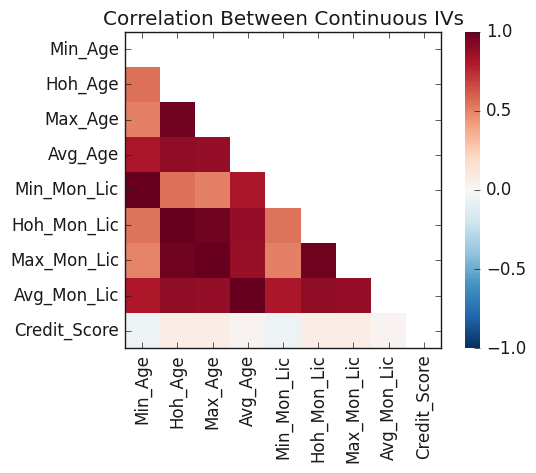

In [300]:
from yellowbrick.features import Rank2D

visualizer1 = Rank2D(algorithm = 'pearson', 
                     size = (596,396),
                    title = "Correlation Between Continuous IVs")

visualizer1.fit_transform(KDD_SF[Quant_Preds])
visualizer1.show();

Commentary:

There are strong, positive correlations between: 
1) averages of age and max/mins of age. 
2) ages and duration of time with licenses held in the household

Well, this is unsurprising. Older individuals live with other older individuals, and they've been driving for a while. And vice-versa. 
I was somewhat surprised that average age and average number of violations isn't correlated, but then maybe this isn't being asked specifically enough.
That is, if you've been driving for only a couple of years (and are young and wild), you might have had a lot of violations, but you've only had a very brief time to collect them.
If you're older, you might have only the occassional violation, but over 50 years, that's still 50 violations.
A better metric for us would be a ratio of violations to time-driving: 50 violations over 50 years yields 1, versus 50 violations over 2 years yields 25, and that's a lot more indicative of driver quality. 

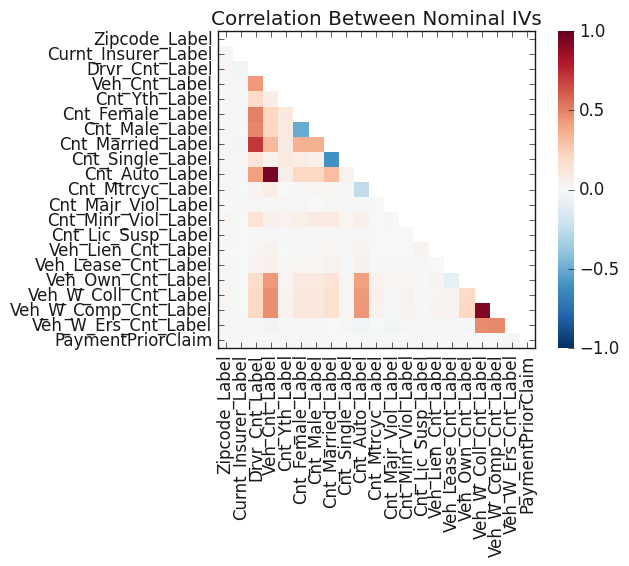

In [301]:
visualizer2 = Rank2D(algorithm = 'pearson', 
                     size = (596,396),
                    title = "Correlation Between Nominal IVs")

visualizer2.fit_transform(KDD_SF[Nom_Preds])
visualizer2.show();

Commentary: 

Strictly speaking, the use of a pearson correlation coeffecient with categorical data like this is not best practice. Contingency tables and the associated metrics (chi-square, phi, Matthew's, etc.) are more appropriate (though for binary predictors, Pearson's and phi are equivalent. However, in this case, we are trying to get merely a snapshot of where to pay attention, and this is an adequate approximation for doing that. Yellowbrick does permit the use of Kendall's Tau, which (as you can see below) is somewhat more appropriate, and yields very similar results.

That said, we can see here:
1) There is a nearly perfect correlation between the variables 'cnt_auto' and 'veh_cnt.' The metadata doesn't clarify this except to say 'number of vehicles' and 'number of automobiles.' 
Without definitions thereof, I can only speculate this means motorcycles, boats, tractors, etc. 
This is almost self-evident: The vast majority of people don't own any of the above, so their vehicle counts will equal their automobile counts. 

2) People who buy collision insurance also buy comprehensive insurance. The prudent, wealthy, default-to-reccomendations, and new-car-owning will likely not customize, would be my guess.
Likewise, there's a fairly strong correlation between the purchase of collision, comprehensive, *and* emergency roadside assistance. 

3) More vehicles correlates with *owning* and *insuring* more vehicles. No surprise there.

4) More *people* in the house correlates with more *drivers* in the house. 


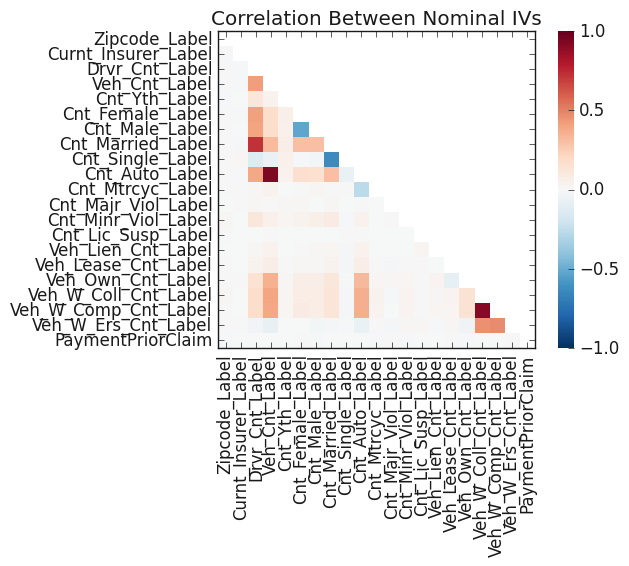

In [302]:
visualizer2_5 = Rank2D(algorithm = 'kendalltau', 
                     size = (596,396),
                    title = "Correlation Between Nominal IVs")

visualizer2_5.fit_transform(KDD_SF[Nom_Preds])
visualizer2_5.show();

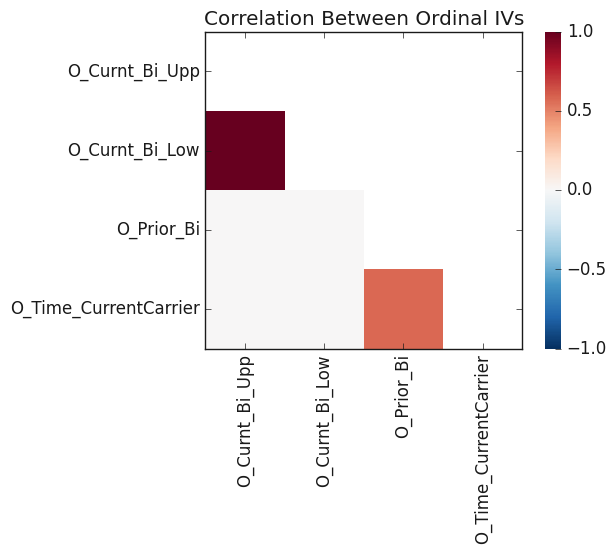

In [303]:
visualizer3 = Rank2D(algorithm = 'pearson', 
                     size = (596,396),
                    title = "Correlation Between Ordinal IVs")

visualizer3.fit_transform(KDD_SF[Ord_Preds])
visualizer3.show();

Commentary: 

1) For bodily injury coverage, *occurence* limits correlate with *individual* limits. 

2) Folks who have been with their current insurer for longer tend to have higher bodily injury individual coverage limits. 



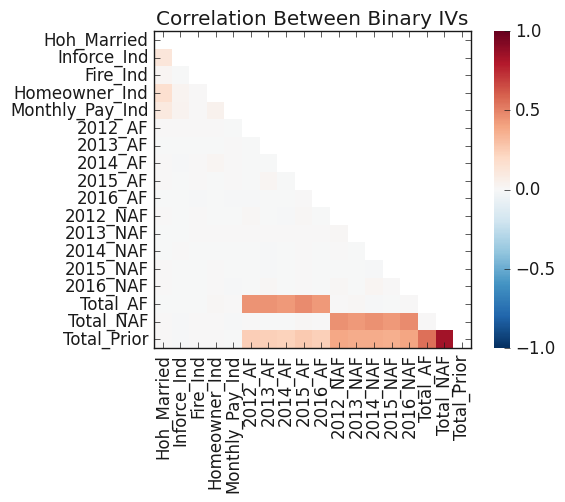

In [304]:
visualizer4 = Rank2D(algorithm = 'pearson', 
                     size = (596,396),
                    title = "Correlation Between Binary IVs")

visualizer4.fit_transform(KDD_SF[Bin_Preds])
visualizer4.show();

Commentary: 

This is really not a terribly useful nor informative subset, as it roughly translates to "Having accidents correlates with having accidents."

Given the above, I think the following are justified in terms of dimensionality, collinearity, and redundancy reduction.
- The past-5-years claims can be consolidated into just the at-fault and not-at-fault totals.
- The current bodily injury limits can be folded into one metric.
- The vehicle and automobile counts can be folded into one metric. 
- The single/married counts can be made into one binary: married y/n. Cnt_Married and Hoh_Married seem unlikely to meaningfully differ to me.
- The min_/max_/hoh_/avg_ ages and months licensed can each be captured by one or the other.
- The household months licensed and household max-months licensed can be captured by one or the other.
- The household age and maximum age can be captured by one or the other (and, as above, both are captured by months licensed).

Here we go!

In [305]:
Drop_List = []
for i in Var_List: 
    if i.startswith('20'):
        Drop_List.append(i)
        try:
            Bin_Preds.remove(i)
        except:
            continue

In [306]:
KDD_SF.drop(columns = Drop_List, inplace = True)

In [307]:
Drop_Cols = ['Hoh_Age', 'Max_Age', 'Min_Age', 'Avg_Age', 'Max_Mon_Lic']
KDD_SF.drop(columns = Drop_Cols, inplace = True)

In [308]:
for dc in Drop_Cols:
    Quant_Preds.remove(dc)

In [309]:
KDD_SF.Cnt_Married_Label.value_counts()

0    10791
2     5657
1     3463
3       79
4       10
Name: Cnt_Married_Label, dtype: int64

In [310]:
KDD_SF.Hoh_Married.value_counts()

0    10791
1     9209
Name: Hoh_Married, dtype: int64

The first of the marriage-related variables asks how many married folks there are, while the second asks if the head-of-household is married. Bizarrely, the former has 3.5k people reporting that there is exactly one married driver in the house...does the spouse not drive, or does the spouse not live in the same home? All of it seems a little weird; I'm going to drop the count and keep the Hoh.

In [311]:
KDD_SF.drop('Cnt_Married_Label', axis = 1, inplace = True)

In [312]:
KDD_SF.drop('Veh_Cnt_Label', axis = 1, inplace= True)

In [313]:
Nom_Preds.remove('Cnt_Married_Label')

In [314]:
Nom_Preds.remove('Veh_Cnt_Label')

In [315]:
for i in Nom_Preds:
    print(i)

Zipcode_Label
Curnt_Insurer_Label
Drvr_Cnt_Label
Cnt_Yth_Label
Cnt_Female_Label
Cnt_Male_Label
Cnt_Single_Label
Cnt_Auto_Label
Cnt_Mtrcyc_Label
Cnt_Majr_Viol_Label
Cnt_Minr_Viol_Label
Cnt_Lic_Susp_Label
Veh_Lien_Cnt_Label
Veh_Lease_Cnt_Label
Veh_Own_Cnt_Label
Veh_W_Coll_Cnt_Label
Veh_W_Comp_Cnt_Label
Veh_W_Ers_Cnt_Label
PaymentPriorClaim


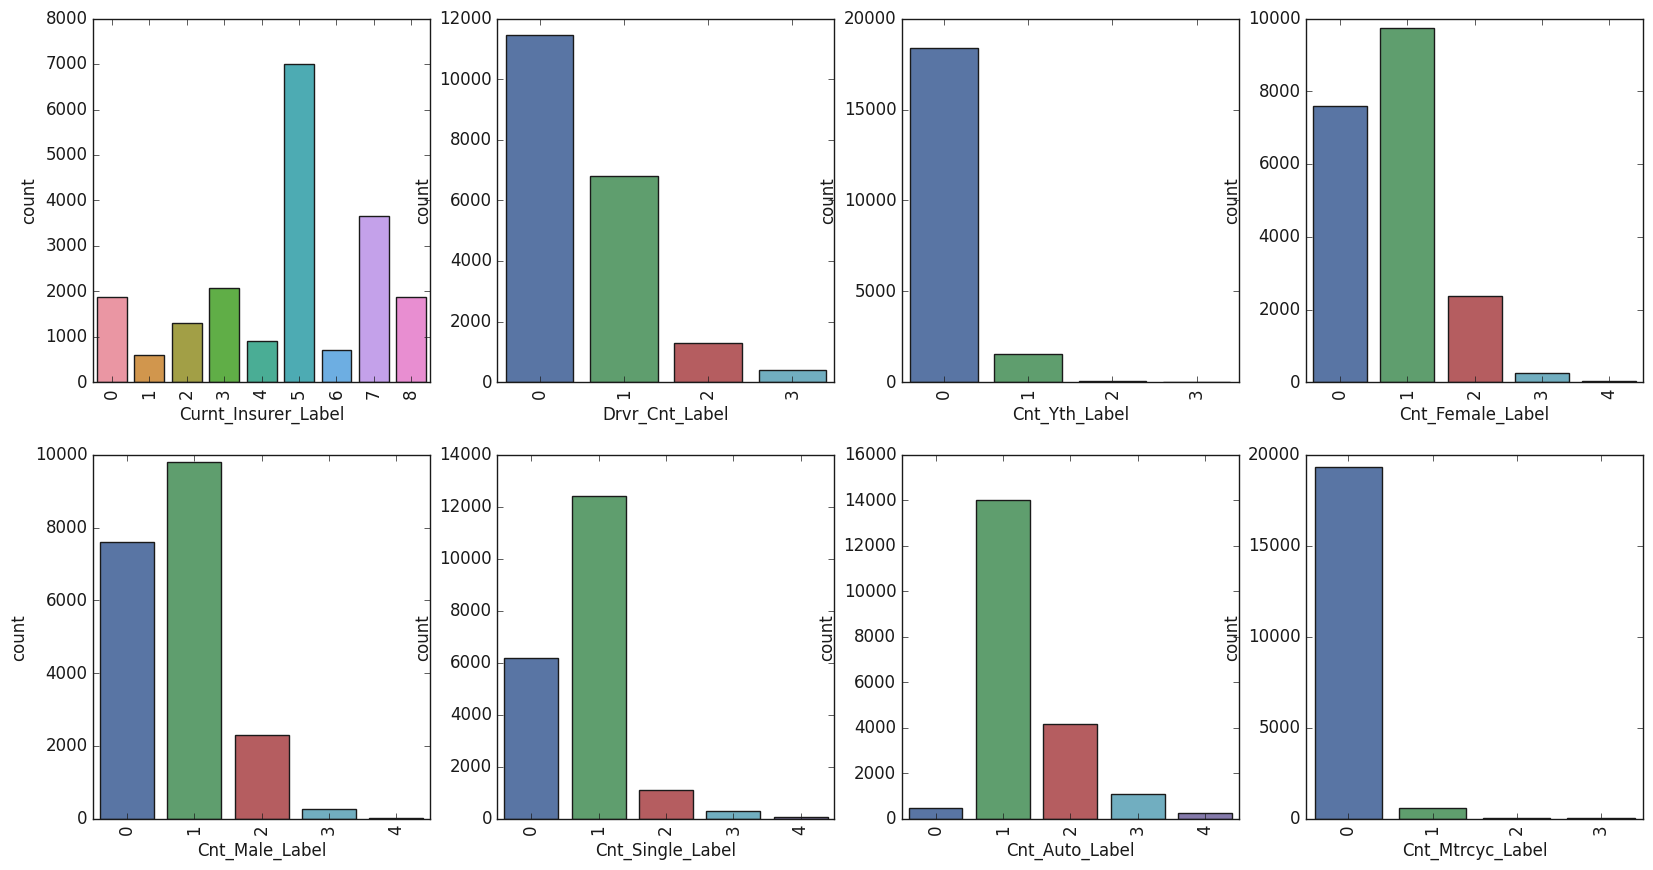

In [316]:
#Examining the distributions of the remaining Nom_Preds, excluding zip-code which has too many groups.
fig, ax = plt.subplots(2,4,figsize = (20,10))
for variable, subplot in zip(Nom_Preds[1:9], ax.flatten()):
    sns.countplot(x = KDD_SF[variable], ax = subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

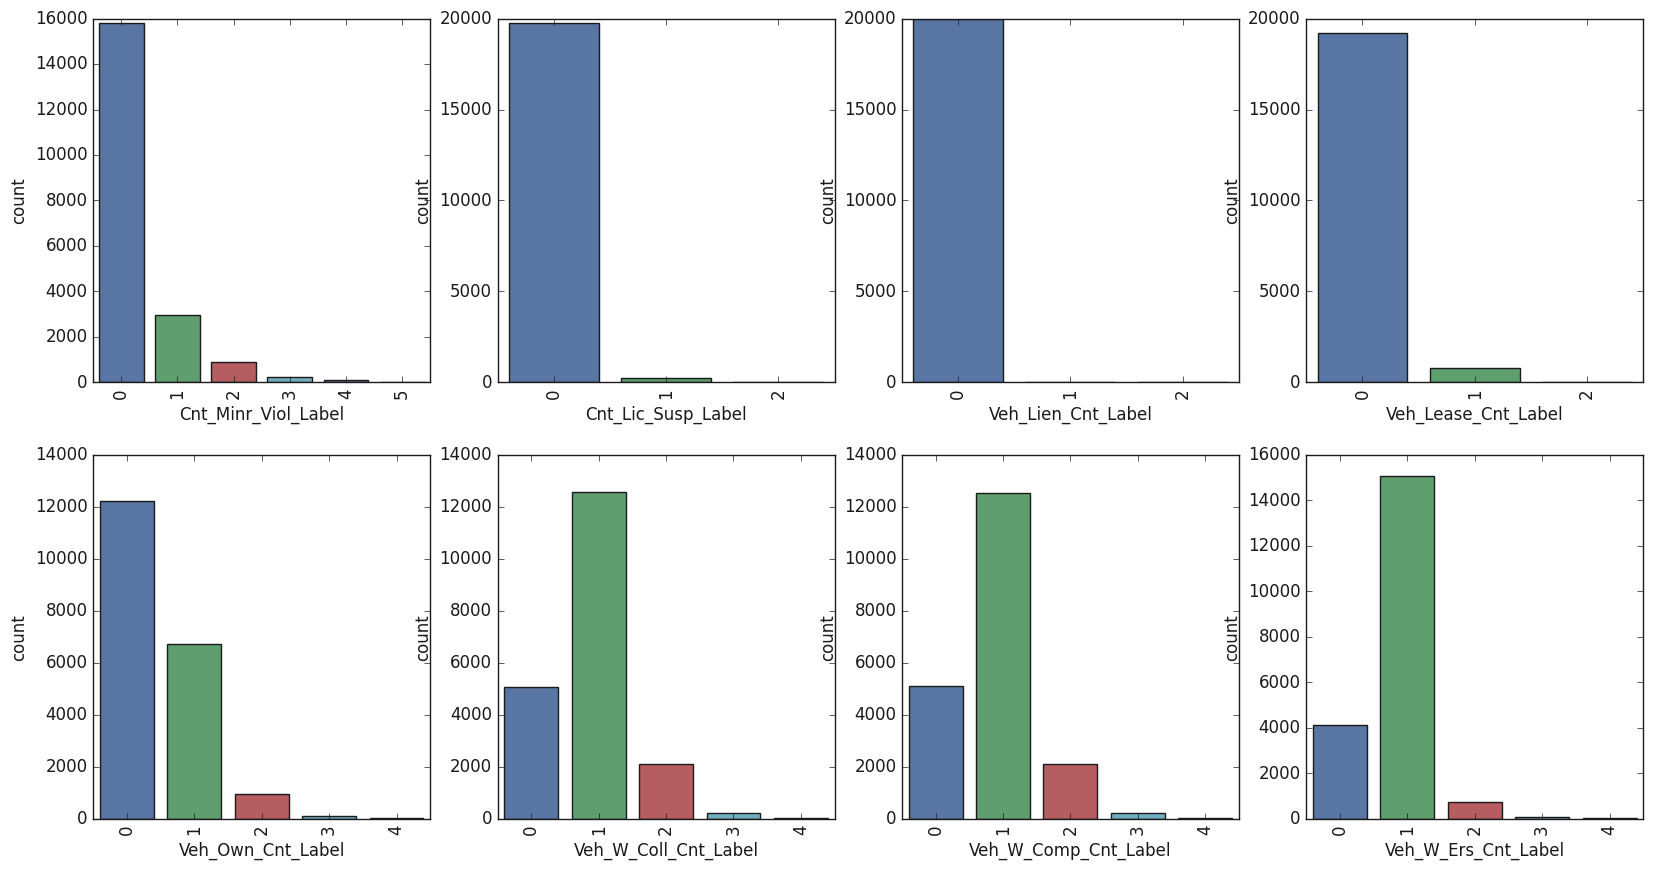

In [317]:
fig, ax = plt.subplots(2,4,figsize = (20,10))
for variable, subplot in zip(Nom_Preds[10:18], ax.flatten()):
    sns.countplot(x = KDD_SF[variable], ax = subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

Total Bi_Low: 10798
Total Bi_Upp: 10798


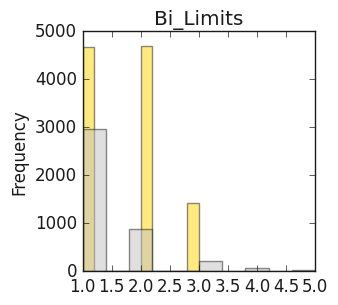

In [318]:
Bi_Low = KDD_SF.O_Curnt_Bi_Low.loc[KDD_SF.O_Curnt_Bi_Low !=0]
print(f'Total Bi_Low: {len(Bi_Low)}')
plt.title('Bi_Limits')
Bi_Low.plot.hist(figsize = (3,3), color = 'gold', alpha = 0.5)
Bi_Upp= KDD_SF.O_Curnt_Bi_Upp.loc[KDD_SF.O_Curnt_Bi_Upp !=0]
print(f'Total Bi_Upp: {len(Bi_Upp)}')
minorV_count.plot.hist(figsize = (3,3), color = 'silver', alpha = 0.5);

In [319]:
KDD_SF.O_Curnt_Bi_Low.value_counts()

0.0    9202
2.0    4698
1.0    4669
3.0    1431
Name: O_Curnt_Bi_Low, dtype: int64

In [320]:
KDD_SF.O_Curnt_Bi_Upp.value_counts()

0.0    9202
2.0    4698
1.0    4669
3.0    1431
Name: O_Curnt_Bi_Upp, dtype: int64

Yeah, it looks like these are carrying identical information. 

In [321]:
KDD_SF.drop('O_Curnt_Bi_Low', axis = 1, inplace = True)

In [322]:
Ord_Preds.remove('O_Curnt_Bi_Low')

In [323]:
KDD_SF.rename(columns = {'O_Curnt_Bi_Upp': 'Bi_Cov'})

,Cust_ID,Min_Mon_Lic,Hoh_Mon_Lic,Avg_Mon_Lic,Hoh_Married,Inforce_Ind,Fire_Ind,Homeowner_Ind,Monthly_Pay_Ind,Credit_Score,YFutureClaim,Total_AF,Total_NAF,Total_Prior,Zipcode_Label,Curnt_Insurer_Label,Drvr_Cnt_Label,Cnt_Yth_Label,Cnt_Female_Label,Cnt_Male_Label,Cnt_Single_Label,Cnt_Auto_Label,Cnt_Mtrcyc_Label,Cnt_Majr_Viol_Label,Cnt_Minr_Viol_Label,Cnt_Lic_Susp_Label,Veh_Lien_Cnt_Label,Veh_Lease_Cnt_Label,Veh_Own_Cnt_Label,Veh_W_Coll_Cnt_Label,Veh_W_Comp_Cnt_Label,Veh_W_Ers_Cnt_Label,Bi_Cov,O_Prior_Bi,O_Time_CurrentCarrier,PaymentPriorClaim
0,1,474.900460,446.286652,446.286652,0,1,0,0,1,698.933117,0,0.0,0.0,0.0,45,3,0,0,0,1,1,1,0,0,0,0,0,0,0,1,1,1,0.0,3.0,0.0,0
1,2,327.285898,327.285898,327.285898,0,1,1,0,1,703.696350,0,0.0,1.0,1.0,8,3,0,0,1,0,1,1,0,0,0,0,0,0,0,1,1,1,2.0,1.0,0.0,1
2,3,110.815758,195.557459,153.186608,1,0,1,1,1,804.472487,0,0.0,0.0,0.0,69,5,1,0,1,1,0,1,0,0,0,0,0,0,1,1,1,1,0.0,0.0,0.0,0
3,4,508.697725,508.697725,508.697725,1,1,0,0,0,648.400880,0,0.0,0.0,0.0,40,3,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,1,0.0,1.0,1.0,0
4,5,295.852339,453.965637,374.908988,1,1,1,1,1,697.084985,0,0.0,0.0,0.0,29,7,1,0,0,2,0,1,0,0,0,0,0,0,1,1,1,1,0.0,1.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,357.703048,357.703048,357.703048,0,0,0,0,1,616.729344,0,0.0,0.0,0.0,79,5,0,0,0,1,1,1,0,0,0,0,0,0,0,1,1,1,1.0,0.0,0.0,0
19996,19997,434.143629,434.143629,434.143629,0,0,0,0,0,740.122456,0,0.0,1.0,1.0,106,5,0,0,1,0,1,2,0,0,1,0,0,0,0,2,2,2,3.0,0.0,0.0,1
19997,19998,278.479529,372.416728,325.448128,1,1,0,1,0,780.246976,0,0.0,0.0,0.0,47,2,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0.0,2.0,0.0,0
19998,19999,1.658285,301.895404,208.615790,1,1,0,0,1,568.880555,1,0.0,0.0,0.0,49,3,3,2,3,1,1,2,0,0,0,0,0,0,0,1,1,1,2.0,1.0,2.0,0


In [324]:
Ord_Preds.remove('O_Curnt_Bi_Upp')
Ord_Preds.append('O_Curnt_Bi_Upp')

Looks pretty good. 36 predictors is still a lot, though, and I've no indication that all of them are helpful in making any predictions. 

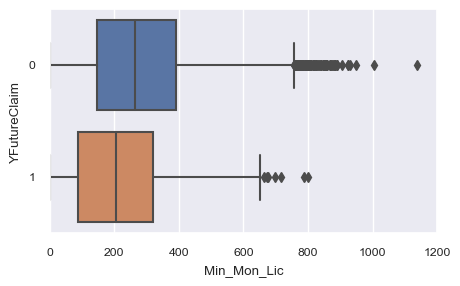

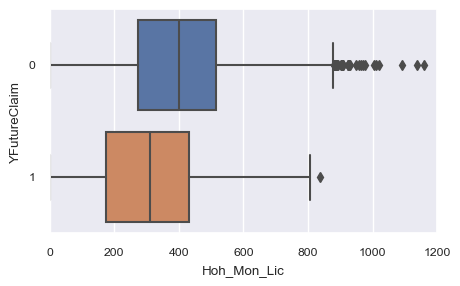

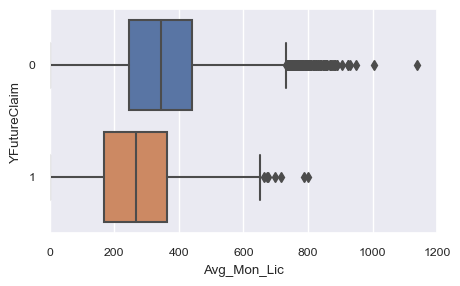

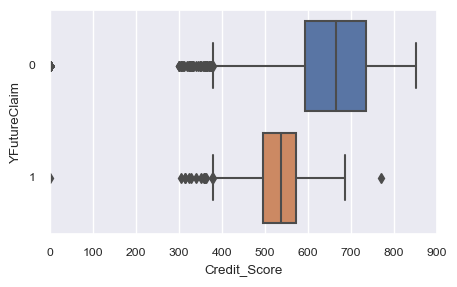

In [325]:
sns.set(rc={'figure.figsize':(5,2.8)}, font_scale = 0.8)

for col in Quant_Preds:
    sns.boxplot(y = KDD_SF['YFutureClaim'].astype('category'), x = col, data=KDD_SF)
    plt.show()

There is a great deal of similarity between the three 'Months-licensed' variables, both in absolute values and in relationship to future claim distribution. This can probably be captured sufficiently by just one of these. 

Lower credit score appears to be significantly predictive. 

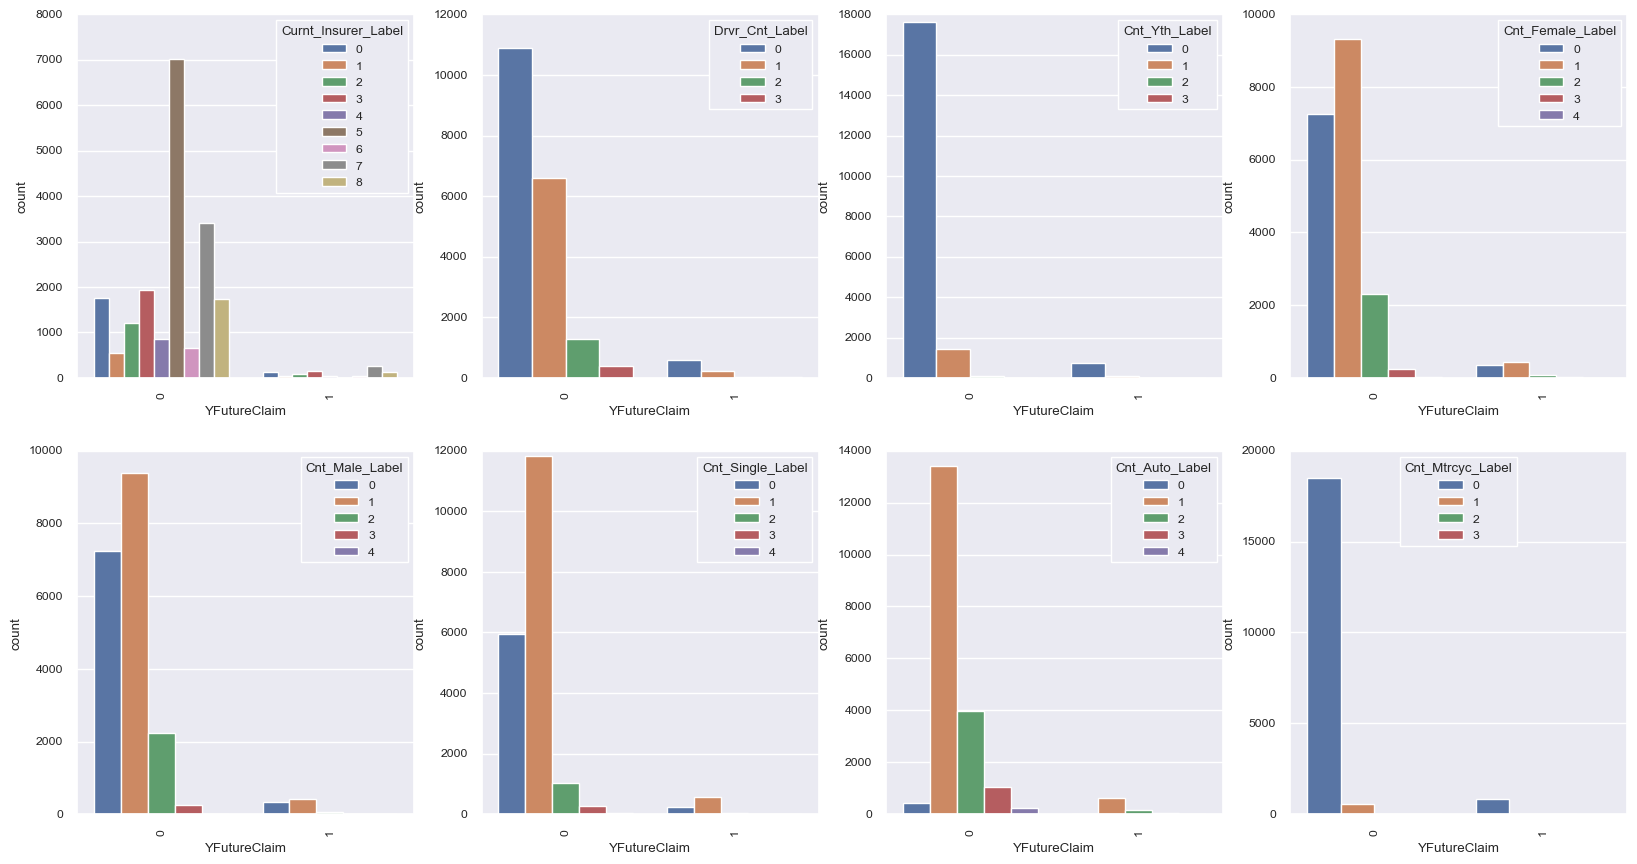

In [326]:
fig, ax = plt.subplots(2,4,figsize = (20,10))
for variable, subplot in zip(Nom_Preds[1:9], ax.flatten()):
    sns.countplot(x = KDD_SF['YFutureClaim'], ax = subplot, hue= KDD_SF[variable])
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

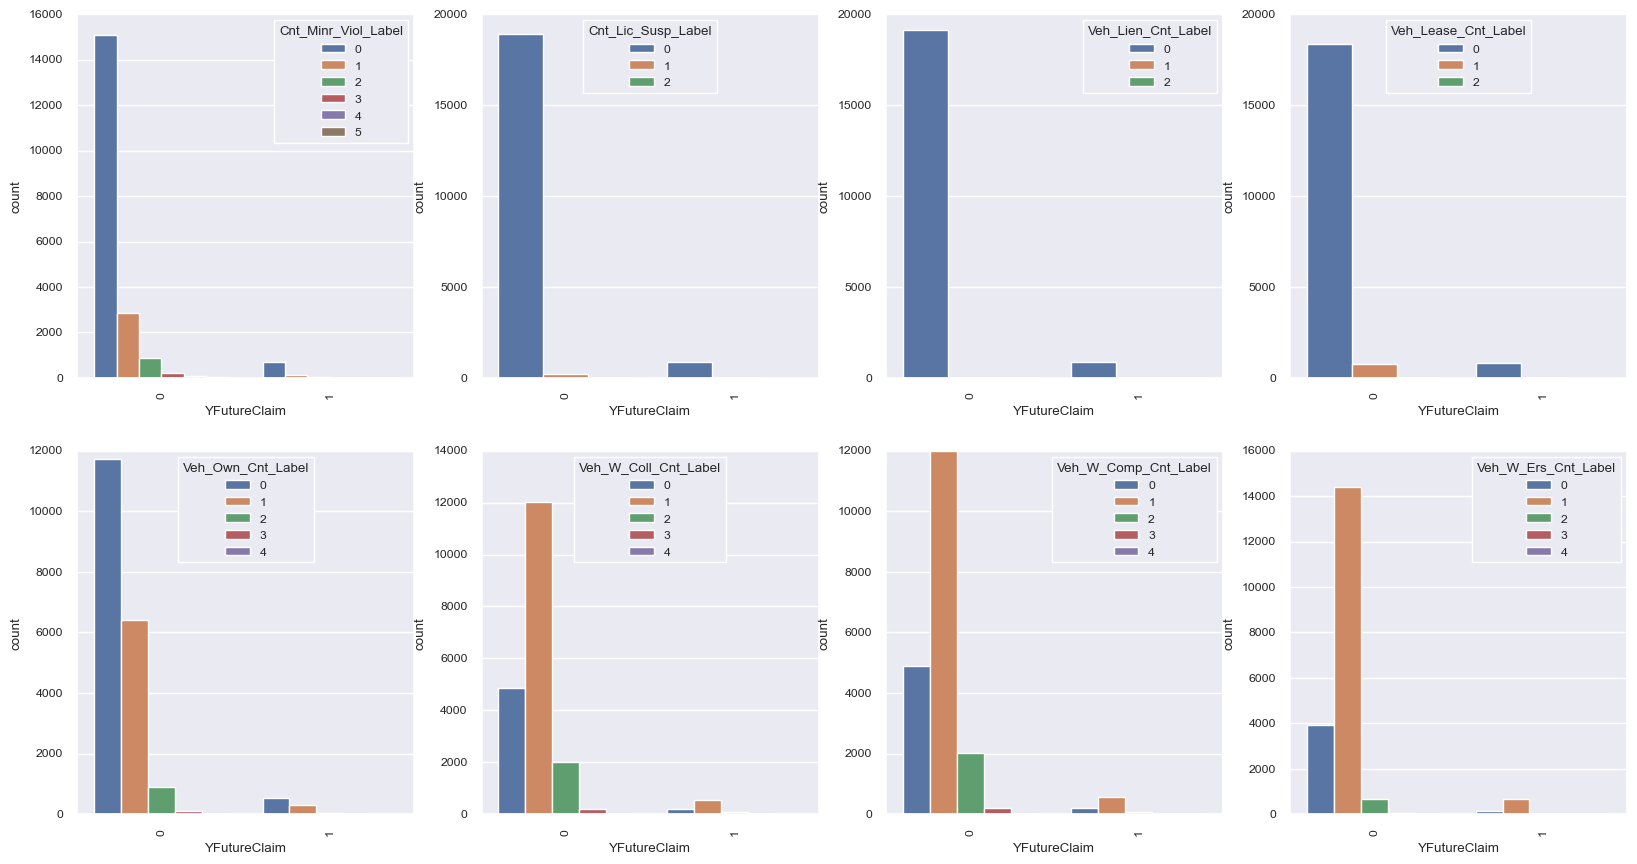

In [327]:
fig, ax = plt.subplots(2,4,figsize = (20,10))
for variable, subplot in zip(Nom_Preds[10:18], ax.flatten()):
    sns.countplot(x = KDD_SF['YFutureClaim'], ax = subplot, hue= KDD_SF[variable])
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

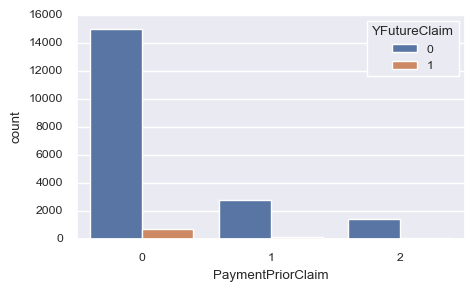

In [328]:
sns.countplot(x = KDD_SF['PaymentPriorClaim'], hue = KDD_SF['YFutureClaim']);

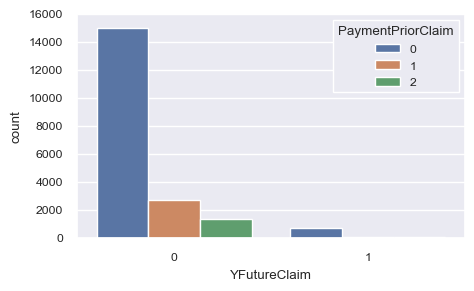

In [329]:
sns.countplot(x = KDD_SF['YFutureClaim'], hue = KDD_SF['PaymentPriorClaim']);

In [330]:
for i in Nom_Preds[1:]:
    predX = KDD_SF[i]
    claimY = KDD_SF['YFutureClaim']
    Ct = pd.concat([predX, claimY], axis = 1)
    CrsTab = pd.crosstab(predX, claimY, margins = True, normalize = 'index')
    print(CrsTab, '\n')

YFutureClaim                0         1
Curnt_Insurer_Label                    
0                    0.930393  0.069607
1                    0.932546  0.067454
2                    0.933795  0.066205
3                    0.931698  0.068302
4                    0.942094  0.057906
5                    0.999857  0.000143
6                    0.940762  0.059238
7                    0.930423  0.069577
8                    0.935657  0.064343
All                  0.956550  0.043450 

YFutureClaim           0         1
Drvr_Cnt_Label                    
0               0.949132  0.050868
1               0.967898  0.032102
2               0.976941  0.023059
3               0.911058  0.088942
All             0.956550  0.043450 

YFutureClaim          0         1
Cnt_Yth_Label                    
0              0.959066  0.040934
1              0.933290  0.066710
2              0.851064  0.148936
3              0.833333  0.166667
All            0.956550  0.043450 

YFutureClaim             0     

In general, it's hard to detect differences in these plots or charts, as the future claim positive outcome is so rare:

----------------  -------------  ----------
No Future Claims  Future Claims  Percentage
19131             869            4.345
----------------  -------------  ----------


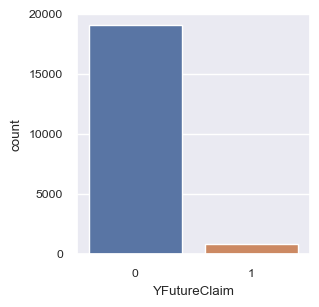

In [331]:
from tabulate import tabulate

a = len(KDD_SF.loc[KDD_SF['YFutureClaim']==0])
b = len(KDD_SF.loc[KDD_SF['YFutureClaim']==1])
claimsData = [["No Future Claims", "Future Claims", "Percentage"], [a, b, round((b/(a+b))*100, 3)]]
print(tabulate(claimsData))

sns.set({'figure.figsize': (3,3)})
sns.countplot(x = KDD_SF['YFutureClaim'],);

I think rather than searching through the whole, it may be more productive to examine what things look like only amongst those who in fact had future claims. By identifying what characterizes that group, we may be able to subset the variables that are most predictive, then standarize everything in such a way that they are distinctive to the learner. 

In [332]:
KDD_SF.to_csv('CheckpointEDA', index= False, index_label = False)

In [333]:
ClaimPos = KDD_SF.copy(deep = True)
ClaimPos_1 = ClaimPos.loc[ClaimPos['YFutureClaim']==1]
ClaimNeg_1 = ClaimPos.loc[ClaimPos['YFutureClaim']==0]

In [334]:
len(ClaimPos_1)

869

In [335]:
ClaimPos_1.describe()

,Cust_ID,Min_Mon_Lic,Hoh_Mon_Lic,Avg_Mon_Lic,Hoh_Married,Inforce_Ind,Fire_Ind,Homeowner_Ind,Monthly_Pay_Ind,Credit_Score,YFutureClaim,Total_AF,Total_NAF,Total_Prior,Zipcode_Label,Curnt_Insurer_Label,Drvr_Cnt_Label,Cnt_Yth_Label,Cnt_Female_Label,Cnt_Male_Label,Cnt_Single_Label,Cnt_Auto_Label,Cnt_Mtrcyc_Label,Cnt_Majr_Viol_Label,Cnt_Minr_Viol_Label,Cnt_Lic_Susp_Label,Veh_Lien_Cnt_Label,Veh_Lease_Cnt_Label,Veh_Own_Cnt_Label,Veh_W_Coll_Cnt_Label,Veh_W_Comp_Cnt_Label,Veh_W_Ers_Cnt_Label,O_Curnt_Bi_Upp,O_Prior_Bi,O_Time_CurrentCarrier,PaymentPriorClaim
count,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.0,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000
mean,10010.304948,217.427234,304.032798,266.457404,0.383199,0.998849,0.387802,0.434983,0.272727,530.282782,1.0,0.048331,0.117376,0.165708,56.759494,4.428078,0.448792,0.153049,0.733026,0.715765,0.841197,1.314154,0.028769,0.031070,0.250863,0.011507,0.004603,0.026467,0.464902,0.872267,0.875719,0.850403,0.929804,1.005754,1.283084,0.268124
std,5790.530166,157.744024,177.210980,150.542605,0.486446,0.033923,0.487530,0.496040,0.445618,62.419000,0.0,0.214589,0.346190,0.413117,32.828853,2.873435,0.756669,0.411029,0.715257,0.699567,0.614799,0.646896,0.174004,0.280226,0.608420,0.106715,0.083013,0.160613,0.626029,0.611734,0.609617,0.473433,0.987665,0.131331,0.685903,0.578540
min,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5118.000000,89.063836,174.627570,168.496292,0.000000,1.000000,0.000000,0.000000,0.000000,494.470615,1.0,0.000000,0.000000,0.000000,28.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
50%,10237.000000,203.848019,310.262292,268.061261,0.000000,1.000000,0.000000,0.000000,0.000000,536.432800,1.0,0.000000,0.000000,0.000000,57.000000,4.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,14816.000000,318.957126,431.058992,362.388568,1.000000,1.000000,1.000000,1.000000,1.000000,571.144600,1.0,0.000000,0.000000,0.000000,86.000000,7.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,0.000000
max,19999.000000,799.592478,836.841488,799.592478,1.000000,1.000000,1.000000,1.000000,1.000000,769.280786,1.0,1.000000,2.000000,2.000000,112.000000,8.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,2.000000,5.000000,5.000000,1.000000,2.000000,1.000000,3.000000,3.000000,4.000000,4.000000,3.000000,4.000000,2.000000,2.000000


In [336]:
a = pd.Series(ClaimPos_1.mean())
b = pd.Series(ClaimNeg_1.mean())
c = pd.concat([a, b], axis = 1, keys = ['Y_futureClaim','N_futureClaim'])
c = pd.DataFrame(c)
c['Difference'] = c['Y_futureClaim'].sub(c['N_futureClaim'], axis = 0)
c

,Y_futureClaim,N_futureClaim,Difference
Cust_ID,10010.304948,10000.054623,10.250325
Min_Mon_Lic,217.427234,276.205764,-58.778530
Hoh_Mon_Lic,304.032798,390.380209,-86.347411
Avg_Mon_Lic,266.457404,342.567326,-76.109922
Hoh_Married,0.383199,0.463959,-0.080760
Inforce_Ind,0.998849,0.633631,0.365218
Fire_Ind,0.387802,0.399352,-0.011550
Homeowner_Ind,0.434983,0.458889,-0.023906
Monthly_Pay_Ind,0.272727,0.302755,-0.030027
Credit_Score,530.282782,637.754666,-107.471884


So, here we can see average differences between those who did and did not file future claims, suggesting that future claimants have the following significant characteristics: 
- fewer months of licensure
- less likely to be married
- more likely to have active insurance
- lower credit score
- has lower bodily injury limits
- has been with their carrier longer

It's not clear from the above crosstabulation whether zipcode or current insurer make any difference. 

In [337]:
ZipNeg = ClaimNeg_1['Zipcode_Label'].value_counts()
ZipPos = ClaimPos_1['Zipcode_Label'].value_counts()
Zips = pd.concat([ZipPos, ZipNeg], axis = 1, keys = ['ZipPos', 'ZipNeg'])
print(Zips.sort_values('ZipPos', ascending = False))
print(Zips.sort_values('ZipNeg', ascending = False))

    ZipPos  ZipNeg
95      14     160
38      14     157
76      14     165
11      13     171
23      13     146
..     ...     ...
4        3     164
68       3     149
35       3     151
32       2     161
36       2     165

[113 rows x 2 columns]
    ZipPos  ZipNeg
3        8     214
63       8     200
61       8     199
62       9     195
93       9     191
..     ...     ...
74       7     146
75       8     145
31       6     145
83       3     144
77       9     142

[113 rows x 2 columns]


Okay, so this is interesting. The most common future claim zip codes are not the most common overall (which might be expected -- the highest count accident zip codes could reasonably be the zip codes with the most people, period). 

In [338]:
pd.crosstab(ClaimPos['Curnt_Insurer_Label'], ClaimPos['YFutureClaim'], margins = True, normalize = 'index')

YFutureClaim,0,1
Curnt_Insurer_Label,,
0,0.930393,0.069607
1,0.932546,0.067454
2,0.933795,0.066205
3,0.931698,0.068302
4,0.942094,0.057906
5,0.999857,0.000143
6,0.940762,0.059238
7,0.930423,0.069577
8,0.935657,0.064343


The only particularly meaningful difference here looks like company 5, which unfortunately corresponds to the label "missing." 

In [339]:
pd.crosstab(ClaimPos['Cnt_Yth_Label'], ClaimPos['Curnt_Insurer_Label'], margins = True, normalize = 'index')[0:1]

Curnt_Insurer_Label,0,1,2,3,4,5,6,7,8
Cnt_Yth_Label,,,,,,,,,
0,0.092864,0.029557,0.063578,0.104132,0.045398,0.353383,0.035926,0.181808,0.093354


So, it doesn't look like youth/new drivers are disproportionately represented here, so I'm not sure what's going on with the 'missing' insurer label. In any event, the strength of the association isn't lost just because I can't interpret it. 

On the basis of this, I am going to subset the following predictors, and then begin training on the reduced dataset.

In [340]:
Preds2Keep = ['Cust_ID', 
              'Avg_Mon_Lic', 
              'Hoh_Married', 
              'Inforce_Ind', 
              'Credit_Score', 
              'O_Prior_Bi', 
              'Zipcode_Label',
             'Curnt_Insurer_Label',
             'O_Time_CurrentCarrier',
             'YFutureClaim']

In [341]:
Preds2Drop = []
for i in KDD_SF.columns:
    if i not in Preds2Keep:
        Preds2Drop.append(i)

In [342]:
ClaimPos.drop(columns = Preds2Drop, axis = 1, inplace = True)

In [343]:
ClaimPos.head(1)

,Cust_ID,Avg_Mon_Lic,Hoh_Married,Inforce_Ind,Credit_Score,YFutureClaim,Zipcode_Label,Curnt_Insurer_Label,O_Prior_Bi,O_Time_CurrentCarrier
0,1,446.286652,0,1,698.933117,0,45,3,3.0,0.0


In [344]:
ClaimPos.to_csv('ReducedDF', index = False, index_label= False)

### Part 6: Model Building and Validation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spstats
import matplotlib as mpl
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette

%matplotlib inline
sns.set_style('darkgrid')
mpl.style.reload_library() 
mpl.style.use('classic')
mpl.rcParams['figure.facecolor'] = (1,1,1,0)
mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['figure.dpi'] = 100
pd.set_option('display.max_columns',100)

In [2]:
reducedDF = pd.read_csv('ReducedDf', index_col = [0])

In [3]:
reducedDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 1 to 20000
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Avg_Mon_Lic            20000 non-null  float64
 1   Hoh_Married            20000 non-null  int64  
 2   Inforce_Ind            20000 non-null  int64  
 3   Credit_Score           20000 non-null  float64
 4   YFutureClaim           20000 non-null  int64  
 5   Zipcode_Label          20000 non-null  int64  
 6   Curnt_Insurer_Label    20000 non-null  int64  
 7   O_Prior_Bi             20000 non-null  float64
 8   O_Time_CurrentCarrier  20000 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 1.5 MB


In [4]:
reducedDF.head(1)

,Avg_Mon_Lic,Hoh_Married,Inforce_Ind,Credit_Score,YFutureClaim,Zipcode_Label,Curnt_Insurer_Label,O_Prior_Bi,O_Time_CurrentCarrier
Cust_ID,,,,,,,,,
1,446.286652,0,1,698.933117,0,45,3,3.0,0.0


In [5]:
fullDF = pd.read_csv('CheckpointEDA', index_col = [0])

In [6]:
fullDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 1 to 20000
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Min_Mon_Lic            20000 non-null  float64
 1   Hoh_Mon_Lic            20000 non-null  float64
 2   Avg_Mon_Lic            20000 non-null  float64
 3   Hoh_Married            20000 non-null  int64  
 4   Inforce_Ind            20000 non-null  int64  
 5   Fire_Ind               20000 non-null  int64  
 6   Homeowner_Ind          20000 non-null  int64  
 7   Monthly_Pay_Ind        20000 non-null  int64  
 8   Credit_Score           20000 non-null  float64
 9   YFutureClaim           20000 non-null  int64  
 10  Total_AF               20000 non-null  float64
 11  Total_NAF              20000 non-null  float64
 12  Total_Prior            20000 non-null  float64
 13  Zipcode_Label          20000 non-null  int64  
 14  Curnt_Insurer_Label    20000 non-null  int64  
 15  Dr

In [7]:
fullDF.head(1)

,Min_Mon_Lic,Hoh_Mon_Lic,Avg_Mon_Lic,Hoh_Married,Inforce_Ind,Fire_Ind,Homeowner_Ind,Monthly_Pay_Ind,Credit_Score,YFutureClaim,Total_AF,Total_NAF,Total_Prior,Zipcode_Label,Curnt_Insurer_Label,Drvr_Cnt_Label,Cnt_Yth_Label,Cnt_Female_Label,Cnt_Male_Label,Cnt_Single_Label,Cnt_Auto_Label,Cnt_Mtrcyc_Label,Cnt_Majr_Viol_Label,Cnt_Minr_Viol_Label,Cnt_Lic_Susp_Label,Veh_Lien_Cnt_Label,Veh_Lease_Cnt_Label,Veh_Own_Cnt_Label,Veh_W_Coll_Cnt_Label,Veh_W_Comp_Cnt_Label,Veh_W_Ers_Cnt_Label,O_Curnt_Bi_Upp,O_Prior_Bi,O_Time_CurrentCarrier,PaymentPriorClaim
Cust_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,474.90046,446.286652,446.286652,0,1,0,0,1,698.933117,0,0.0,0.0,0.0,45,3,0,0,0,1,1,1,0,0,0,0,0,0,0,1,1,1,0.0,3.0,0.0,0


In [8]:
Ord_Preds = []
Nom_Preds = []
Quant_Preds = []
Bin_Preds = []

for i in fullDF.columns: 
    if i.startswith('O'):
        Ord_Preds.append(i)
    
    if i.endswith('Label') or i.startswith('Payment'):
        Nom_Preds.append(i)
        
    if i.startswith('Avg') or i.startswith('Min') or i == 'Hoh_Age' or i == 'Hoh_Mon_Lic' or i.startswith('Max') or i.endswith('Paid') or i.endswith('Score') or i.endswith('Viol'):
        Quant_Preds.append(i)
        
    if i.endswith('AF') or i.endswith('Prior') or i.endswith('Ind') or i.endswith('Married'):
        Bin_Preds.append(i)

In [9]:
#Sanity check: 
assert (len(Ord_Preds) + len(Nom_Preds) + len(Quant_Preds) + len(Bin_Preds) + 1) == len(fullDF.columns)

Model 1: 

At present, the continuous predictors are not scaled. I suspect, however, that a non-distance-based classifier (e.g., tree or forest) will likely perform quite well with this task. Before applying the transformations, I'd like to see how such a model does, and whether we need to bother with it. 

In [10]:
#Model 1 - Full Data Set - Splitting data
xFull = fullDF.drop(columns = 'YFutureClaim')
yFull = fullDF['YFutureClaim']

FullFeatures = xFull.columns
FullLabs = yFull.unique()

from sklearn.model_selection import train_test_split as tts
Xf_train, Xf_test, yf_train, yf_test = tts(xFull, yFull, test_size = 0.25, random_state = 42)

In [28]:
#Model 2 - Reduced Data Set - Splitting Data
xRed = reducedDF.drop(columns = 'YFutureClaim')
yRed = reducedDF['YFutureClaim']

RedFeatures = xRed.columns
RedLabs = yRed.unique()

Xr_train, Xr_test, yr_train, yr_test = tts(xRed, yRed, test_size = 0.25, random_state = 42)

In [29]:
#Model 1 - Decision Tree - Fit + Accuracy
from sklearn.tree import DecisionTreeClassifier

FullClf = DecisionTreeClassifier(max_depth = 3, random_state = 42)
FullClf.fit(Xf_train, yf_train)
print(f'Accuracy of basic Decision Tree on the full dataset: {FullClf.score(Xf_test, yf_test)}')

Accuracy of basic Decision Tree on the full dataset: 0.976


In [30]:
#Model 2 -- Decision Tree -Fit + Accuracy

RedClf = DecisionTreeClassifier(max_depth = 3, random_state = 42)
RedClf.fit(Xr_train, yr_train)
print(f'Accuracy of basic Decision Tree on the reduced dataset: {RedClf.score(Xr_test, yr_test)}')

Accuracy of basic Decision Tree on the reduced dataset: 0.976


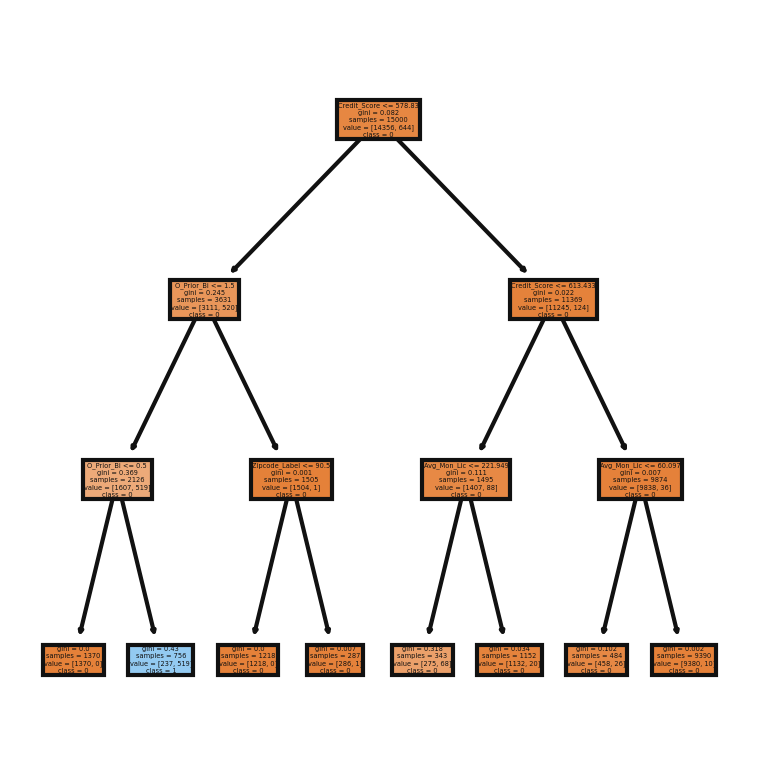

In [52]:
from sklearn import tree
import matplotlib 

fig, ax = plt.subplots(nrows = 1,ncols = 1,figsize = (3,3), dpi=300)

#ax.set_title("# gold medals by country", fontsize=20)

tree.plot_tree(RedClf, 
               feature_names = [i for i in xRed.columns], 
               class_names = [str(i) for i in RedLabs],
               filled = True);

So, this is very positive. First of all, both models -- without any significant parameter-tuning-- produce >97% accuracy. Secondly, our feature-selection/-engineering process appears to have been pretty successful: we achieve just as much accuracy with an 8-predictor model as with a 34-predictor model (i.e., with 1/4 of the complexity). 

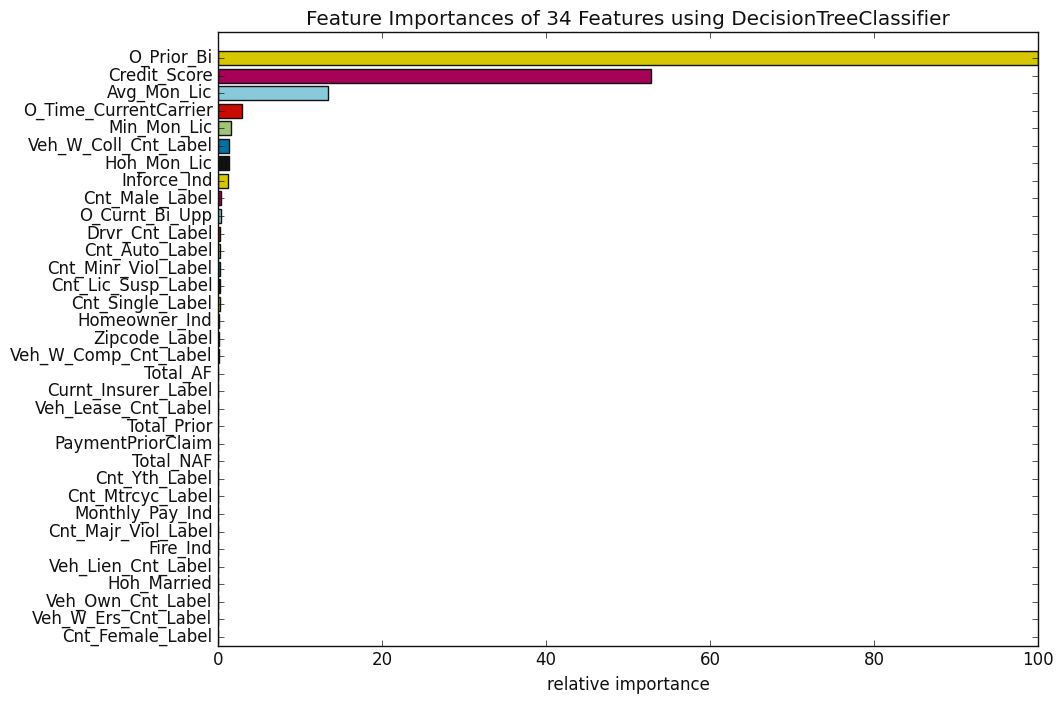

In [46]:
from yellowbrick.model_selection import FeatureImportances

model = DecisionTreeClassifier()
viz = FeatureImportances(model, size = (1080, 720))
viz.fit(Xf_train, yf_train)
viz.show();

In [47]:
print(reducedDF.columns)

Index(['Avg_Mon_Lic', 'Hoh_Married', 'Inforce_Ind', 'Credit_Score',
       'YFutureClaim', 'Zipcode_Label', 'Curnt_Insurer_Label', 'O_Prior_Bi',
       'O_Time_CurrentCarrier'],
      dtype='object')


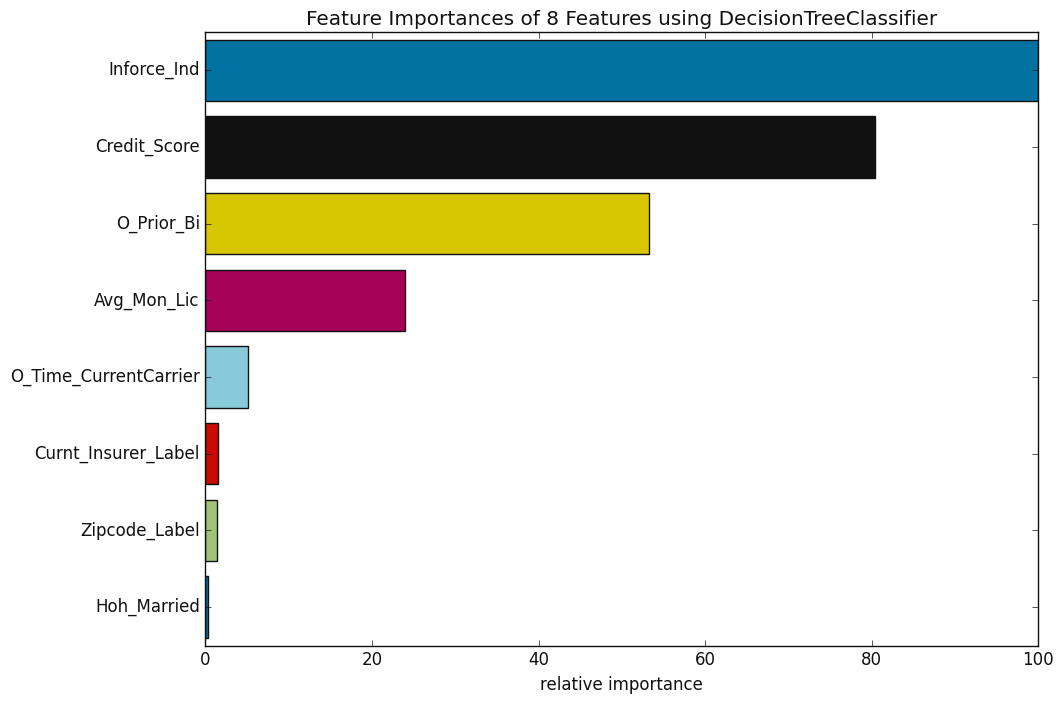

In [48]:
from yellowbrick.model_selection import FeatureImportances

model = DecisionTreeClassifier()
viz = FeatureImportances(model, size = (1080, 720))
viz.fit(Xr_train, yr_train)
viz.show();

Looking at the two graphs above, we can see:
1) that the full dataset model has only about half of its features contributing *anything*, and of those, all three of the (highly correlated) 'min-months-licensed' variables appear, dividing predictive influence among themselves. 
2) Current Insurer, Zipcode, and Marital Status might not be worth keeping.
3) After account for point [1], above, the top-5 predictors in both models are the same: prior_bi, credit score, average months licensed, inforce indicator, and time with current insurer. 
4) The number of vehicles with collision coverage, and the number of male drivers in the household might be worth substituting with 2 of the predictors from [2] above. 

In [49]:
toDrop = ['Zipcode_Label', 'Curnt_Insurer_Label', 'Hoh_Married']
toAdd = ['Cnt_Male_Label', 'Veh_W_Coll_Cnt_Label']

In [50]:
reducedDF.drop(columns = toDrop, axis = 1, inplace = True)

In [51]:
toAddDf = pd.DataFrame(fullDF[toAdd])

In [58]:
revisedDF = pd.merge(reducedDF, toAddDf, how = 'inner', right_index =True, left_index = True)

In [67]:
#Sanity checking / confirming correctness of modifications and merges. 
assert len(revisedDF) == len(fullDF)
assert len(revisedDF.Credit_Score.unique()) == len(fullDF.Credit_Score.unique())
assert revisedDF.Avg_Mon_Lic.mean() == fullDF.Avg_Mon_Lic.mean()

In [69]:
reducedDF.head(1)

,Avg_Mon_Lic,Inforce_Ind,Credit_Score,YFutureClaim,O_Prior_Bi,O_Time_CurrentCarrier
Cust_ID,,,,,,
1,446.286652,1,698.933117,0,3.0,0.0


In [72]:
revisedDF.head(1)

,Avg_Mon_Lic,Inforce_Ind,Credit_Score,YFutureClaim,O_Prior_Bi,O_Time_CurrentCarrier,Cnt_Male_Label,Veh_W_Coll_Cnt_Label
Cust_ID,,,,,,,,
1,446.286652,1,698.933117,0,3.0,0.0,1,1


In [75]:
#Model 3 - Revised Reduced Data Set - Splitting Data
xRed2 = revisedDF.drop(columns = 'YFutureClaim')
yRed2 = revisedDF['YFutureClaim']

RedFeatures2 = xRed2.columns
RedLabs2 = yRed2.unique()

Xr2_train, Xr2_test, yr2_train, yr2_test = tts(xRed2, yRed2, test_size = 0.25, random_state = 42)

In [76]:
#Model 3 - Decision Tree - Fit + Accuracy
RedClf = DecisionTreeClassifier(max_depth = 3, random_state = 42)
RedClf.fit(Xr2_train, yr2_train)
print(f'Accuracy of basic Decision Tree on the revised dataset: {RedClf.score(Xr2_test, yr2_test)}')

Accuracy of basic Decision Tree on the revised dataset: 0.976


Unsurprisingly, given how low they were in terms of predictive power, without changing the depth of the trees, the swapping of predictors doesn't improve accuracy here. However, there are some things we can try. 

Since we have a relatively rare outcome we are trying to predict, and since we have a mix of different predictor data types, a non-parametric classifier is probably the best way to proceed. Given the diverse mix of predictor types, I don't see any reason why a neighbors or SVM algorithm would do better than a tree-variation, so let's proceed with tree-based models and tweak where we can to try and pump the score up. 

In [80]:
#Model 4 - Simple Random Forest - Revised Reduced Data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier()

rfc.fit(Xr2_train, yr2_train)
y_pred = rfc.predict(Xr2_test)

print(f"Simple Random Forest Accuracy on Revised Dataset: {accuracy_score(yr2_test, y_pred)}")

Simple Random Forest Accuracy on Revised Dataset: 0.9966


Very nice. The majority 'voting' procedure in the random forest helps to correct for some of the bias that might have been introduced in a single-tree model.

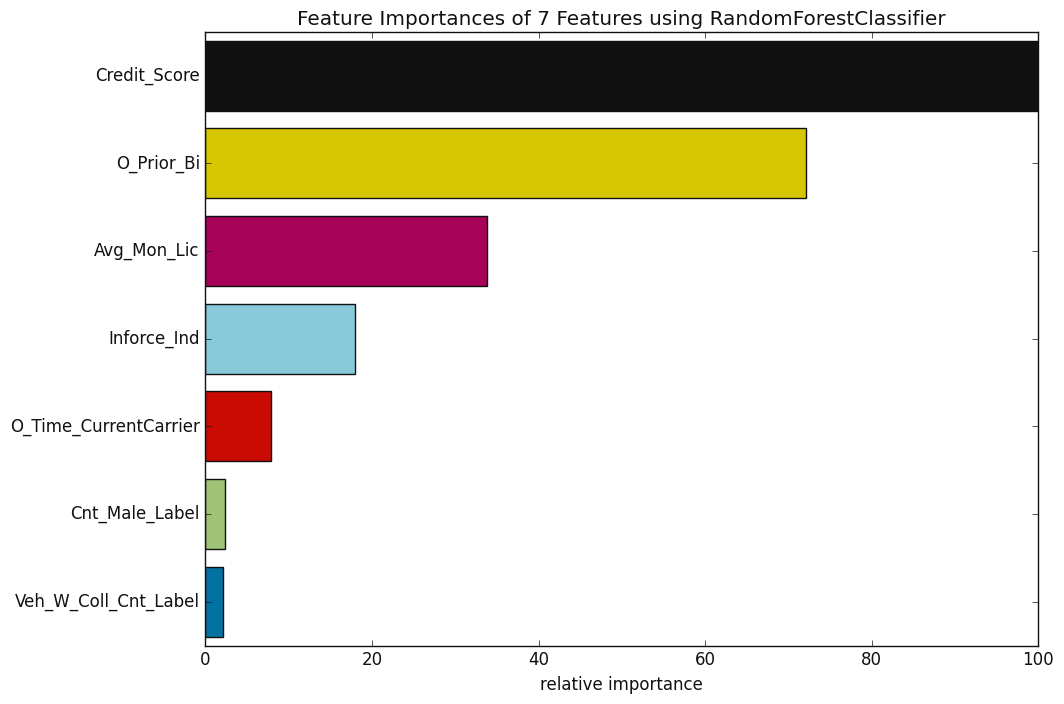

In [81]:
#Model 4 - Visualization of Feature Importances.
from yellowbrick.model_selection import FeatureImportances

model = RandomForestClassifier()
viz = FeatureImportances(model, size = (1080, 720))
viz.fit(Xr2_train, yr2_train)
viz.show();

In [90]:
#Model 5 - Extreme Gradient Boosting Classifier - Revised Reduced Data - Prep
from sklearn.preprocessing import MinMaxScaler
xRed3 = revisedDF.drop(columns = 'YFutureClaim')
yRed3 = revisedDF['YFutureClaim']

scaler = MinMaxScaler()
xRed3[['Credit_Score', 'Avg_Mon_Lic']]= scaler.fit_transform(xRed3[['Credit_Score', 'Avg_Mon_Lic']])

Xr3_train, Xr3_test, yr3_train, yr3_test = tts(xRed3, yRed3, test_size = 0.25, random_state = 42)

In [120]:
#Model 5 - Extreme Gradient Boosting Classifier - Revised Reduced Data - Fit + Accuracy
import time
start = time.time()

from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score

xgb = XGBClassifier(n_estimators = 104, objective = 'binary:hinge', random_state = 42, max_depth = 3)

xgb.fit(Xr3_train, yr3_train)
y_pred = xgb.predict(Xr3_test)

print(f"XGBoostClassifier Accuracy on Revised Dataset: {accuracy_score(yr3_test, y_pred)}", '\n')

end=time.time()

print(f'Execution Time: {end - start}')

XGBoostClassifier Accuracy on Revised Dataset: 0.9968 

Execution Time: 0.3071787357330322


In [122]:
from sklearn.metrics import classification_report
print(classification_report(yr3_test, y_pred))
print('Accuracy: ', accuracy_score(yr3_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4775
           1       0.98      0.95      0.96       225

    accuracy                           1.00      5000
   macro avg       0.99      0.97      0.98      5000
weighted avg       1.00      1.00      1.00      5000

Accuracy:  0.9968


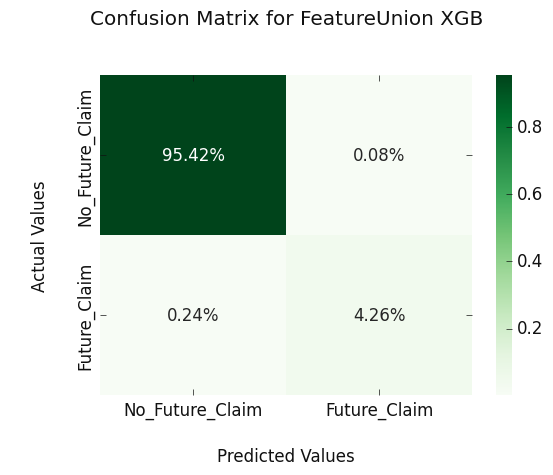

In [124]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(yr3_test, y_pred)
ax = sns.heatmap(cf/np.sum(cf), annot = True, fmt= '.2%', cmap = 'Greens')

ax.set_title('Confusion Matrix for FeatureUnion XGB\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('\nActual Values\n')

ax.xaxis.set_ticklabels(['No_Future_Claim','Future_Claim'])
ax.yaxis.set_ticklabels(['No_Future_Claim','Future_Claim'])
plt.show()

In [119]:
#Validation of model 5; binary classification, using kfold rather than stratified validation method.
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

xRed4 = revisedDF.drop(columns = 'YFutureClaim')
yRed4 = revisedDF['YFutureClaim']

scaler = MinMaxScaler()
xRed4[['Credit_Score', 'Avg_Mon_Lic']]= scaler.fit_transform(xRed4[['Credit_Score', 'Avg_Mon_Lic']])

cvModel = XGBClassifier(n_estimators = 104, objective = 'binary:hinge', random_state =0, max_depth = 3)

kfold = KFold(n_splits = 10, random_state = 7, shuffle = True)
results = cross_val_score(cvModel, xRed4, yRed4, cv = kfold)
print(f'Validation Accuracy of XGBoostClassifer, K = 10 (Mean, Standard Deviation): {round(results.mean()*100, 3), round(results.std()*100, 3)}')

Validation Accuracy of XGBoostClassifer, K = 10 (Mean, Standard Deviation): (99.615, 0.114)


At this point, it's a little bit hard to know how to proceed. With two models with >99% accuracy, it's a matter -- I would think -- of organizational goals how we proceed. We could try to continue improving accuaracy (say, by hyperparameter tuning, fiddling with xgboost, and so on), or we could try to simplify the model yet further (say, by dropping the two lowest performing predictors and then experimentally modifying hyperparameters with grid search or something similar). Likewise, if there was any issue with runtime/computational power, we could explore replacing this model with a variation through LightGBM. However, without that guidance in hand, I rather suspect this document is already too long, so I'll wrap it up with 99.7% accuracy. 

In summary, at the point of merging the three datasets given, we had 57 possible predictors. After eliminating redundant and collinear variables, collapsing self-similar variables, engineering synoptic and/or factor-adjacent variables, and subsetting based on feature importance, we were able to consider only 7 predictive data points and achieve 99.7% accuracy in identifying future claimants.